ВВЕДЕНИЕ

Разработка модели машинного обучения для принятия решения о покупке коров на "Экоферме"

Цель работы -
создать две прогнозные модели для отбора бурёнок в поголовье:

Первая будет прогнозировать возможный удой коровы (целевой признак Удой);

Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
средний удой за год — не менее 6000 килограммов;
молоко должно быть вкусным.


План работы:

1. [предобработка данных](#section1)  (исследование пропусков, дублей, проверка типов данных)
2. [статистический анализ всех признаков](#section2) , построение графиков, исследование выбросов в данных
3. [корреляционный исследовательский анализ:](#section4)  анализ признаков в датасете с описанием стада: расчет коэффициентов корреляции между всеми признаками, нахождение типов взаимосвязи между целевыми и входными признаками
4. [обучение трех моделей простой линейной регрессии](#section5)
5. [обучение модели логистической регрессии](#section6)
6. [итоговые выводы](#section7)

## 1. Загрузка данных

Импортируем библиотеки.

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import phik
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score)

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

Загрузим исходные данные, используя  ';' как разделитель для значений, а  ',' как разделитель десятичных дробей.

In [3]:
try:
    data_ferma = pd.read_csv('/datasets/ferma_main.csv',sep = ';', decimal = ',')
except:
    data_ferma = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv',sep = ';', decimal = ',')

In [4]:
try:
    data_dad = pd.read_csv('/datasets/ferma_dad.csv',sep = ';', decimal = ',')
except:
    data_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv',sep = ';', decimal = ',')

In [5]:
try:
    data_cow = pd.read_csv('/datasets/cow_buy.csv',sep = ';', decimal = ',')
except:
    data_cow = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv',sep = ';', decimal = ',')

Выведем первые строки.

In [6]:
display(data_ferma.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [7]:
display(data_dad.head())

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [8]:
display(data_cow.head())

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Переименуем столбцы во всех датафреймах для удобства работы.


Некоторые столбцы будут пересекаться в таблицах, а именно:
"порода, тип пастбища, порода папы быка, возраст" будут и в data_ferma, и в data_cow,
"имя папы" будет и в data_dad, и в data_cow.

In [9]:
# Переименовываем столбцы
data_ferma=data_ferma.rename(columns={\
                                     'Удой, кг': 'yield', \
                                     'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit',\
                                     'Сырой протеин, г': 'protein_raw',\
                                     'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein',\
                                     'Порода': 'breed',\
                                     'Тип пастбища': 'pasture_type',\
                                     'порода папы_быка': 'dad_breed',\
                                     'Жирность,%': 'fat',\
                                     'Белок,%': 'protein',\
                                     'Вкус молока': 'taste',\
                                     'Возраст': 'age'})

In [10]:
display(data_ferma.head())

,id,yield,energy_feed_unit,protein_raw,sugar_protein,breed,pasture_type,dad_breed,fat,protein,taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [11]:
# Переименовываем столбцы
data_dad=data_dad.rename(columns={'Имя Папы': 'dad_name'})

In [12]:
display(data_dad.head())

,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [13]:
# Переименовываем столбцы
data_cow=data_cow.rename(columns={
                                 'Порода': 'breed', \
                                 'Тип пастбища': 'pasture_type',\
                                 'порода папы_быка': 'dad_breed', \
                                 'Имя_папы': 'dad_name',\
                                 'Текущая_жирность,%': 'fat_currrent',\
                                 'Текущий_уровень_белок,%': 'protein_current',\
                                 'Возраст': 'age'})

In [14]:
display(data_cow.head())

,breed,pasture_type,dad_breed,dad_name,fat_currrent,protein_current,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Теперь все столбцы имеют удобные названия.

<a id='section1'></a>
##  2. Предобработка данных

Для каждого датафрейма выведем общую информацию и количество полных дубликатов.

Для этого напишем функцию, которую применим ко всем трем датафреймам.

In [15]:
def check_df (df):

    # общая информация
    display(df.info())

    # число полных дубликатов
    print(df.duplicated().sum())

In [16]:
check_df(data_ferma)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   yield             634 non-null    int64  
 2   energy_feed_unit  634 non-null    float64
 3   protein_raw       634 non-null    int64  
 4   sugar_protein     634 non-null    float64
 5   breed             634 non-null    object 
 6   pasture_type      634 non-null    object 
 7   dad_breed         634 non-null    object 
 8   fat               634 non-null    float64
 9   protein           634 non-null    float64
 10  taste             634 non-null    object 
 11  age               634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


None

5


В датафрейме data_ferma 634 строки, пропусков нет, дубликатов 5.

Удалим дубликаты.

In [17]:
data_ferma = data_ferma.drop_duplicates()

In [18]:
# проверка корректности удаления дубликатов
print(data_ferma.duplicated().sum())

0


Типы некоторых переменных нужно заменить.

energy_feed_unit, sugar_protein, fat,  protein должны быть вещественными,  protein_raw - целочисленным.

In [19]:
# Создаем список переменных, тип которых нужно заменить
sp=['energy_feed_unit', 'sugar_protein', 'fat', 'protein','protein_raw']

In [20]:
# Меняем тип переменных из строкового в численный
for i in sp:
    data_ferma[i]=pd.to_numeric(data_ferma[i])

In [21]:
# меняем тип protein_raw на целочисленный
data_ferma['protein_raw'] = data_ferma['protein_raw'].astype(int)

In [22]:
# Проверяем преобразование типов
check_df(data_ferma)

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                629 non-null    int64  
 1   yield             629 non-null    int64  
 2   energy_feed_unit  629 non-null    float64
 3   protein_raw       629 non-null    int64  
 4   sugar_protein     629 non-null    float64
 5   breed             629 non-null    object 
 6   pasture_type      629 non-null    object 
 7   dad_breed         629 non-null    object 
 8   fat               629 non-null    float64
 9   protein           629 non-null    float64
 10  taste             629 non-null    object 
 11  age               629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


None

0


Замена типов прошла успешно.

Выведем общую информацию и количество полных дубликатов для датафрейма data_dad.

In [23]:
check_df(data_dad)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

0


В датафрейме data_dad 629 строк, пропусков нет, дубликатов нет. Типы переменных правильные.

Проделаем ту же процедуру с третьим датафреймом.

In [24]:
check_df(data_cow)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed            20 non-null     object 
 1   pasture_type     20 non-null     object 
 2   dad_breed        20 non-null     object 
 3   dad_name         20 non-null     object 
 4   fat_currrent     20 non-null     float64
 5   protein_current  20 non-null     float64
 6   age              20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

4


В data_cow 20 строк, пропусков нет, дубликатов 4.

Удалим дубликаты и проверим корректность удаления.

In [25]:
data_cow=data_cow.drop_duplicates()
print(data_cow.duplicated().sum())

0


Две переменных требуют замены типа со строкового на численный: fat_currrent и protein_current.

In [26]:
# Меняем тип переменных из строкового в численный
data_cow['fat_currrent']=pd.to_numeric(data_cow['fat_currrent'],errors='coerce')
data_cow['protein_current']=pd.to_numeric(data_cow['protein_current'],errors='coerce')

In [27]:
# Проверяем преобразование типов
check_df(data_cow)

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed            16 non-null     object 
 1   pasture_type     16 non-null     object 
 2   dad_breed        16 non-null     object 
 3   dad_name         16 non-null     object 
 4   fat_currrent     16 non-null     float64
 5   protein_current  16 non-null     float64
 6   age              16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


None

0


Итого, все датафреймы проверены на пропуски, дубликаты, имеют правильные типы переменных.

Данные готовы к обработке.

<a id='section2'></a>
## 3. Исследовательский анализ данных

3.1 Построем гистограммы для всех числовых столбцов в таблице data_ferma.

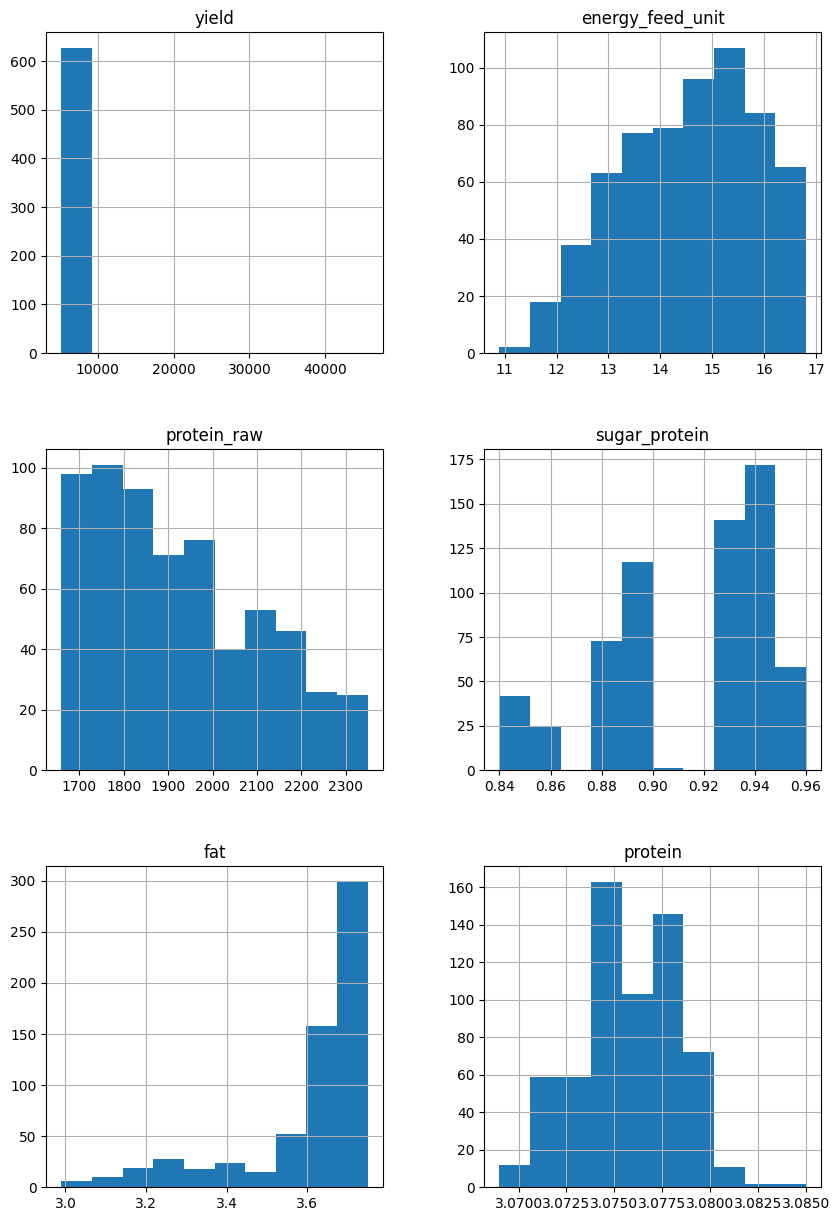

In [28]:
data_ferma.drop('id',axis=1).hist(figsize=(10, 15));

Первое, что бросается в глаза - явный выброс в переменной yield.

Найдем этот выброс.

In [29]:
# Выведем все строки с yield больше 10000
display(data_ferma[data_ferma['yield']>10000])

,id,yield,energy_feed_unit,protein_raw,sugar_protein,breed,pasture_type,dad_breed,fat,protein,taste,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиалл,3.22,3.076,вкусно,более_2_лет


Посмотрим, каие значения принимает переменная yield.

In [30]:
display(data_ferma['yield'].describe())

,yield
count,629.000000
mean,6188.750397
std,1644.795489
min,5204.000000
25%,5751.000000
50%,6133.000000
75%,6501.000000
max,45616.000000


Среднее значение 6187, минимальное 5204.

Скорее всего, в числе 45616 ошибочно прописали первую цифру 4. Если ее убрать, останется 5616 - вполне похожее на истинное значение. Поэтому исправим это значение на 5616.

In [31]:
data_ferma.loc[16,'yield']=5616

<a id='section3'></a>
Посмотрим, как изменятся статистические характеристики переменной yield после замены, и построим гистограмму.

In [32]:
display(data_ferma['yield'].describe())

,yield
count,629.000000
mean,6125.157393
std,475.912622
min,5204.000000
25%,5746.000000
50%,6132.000000
75%,6501.000000
max,7222.000000


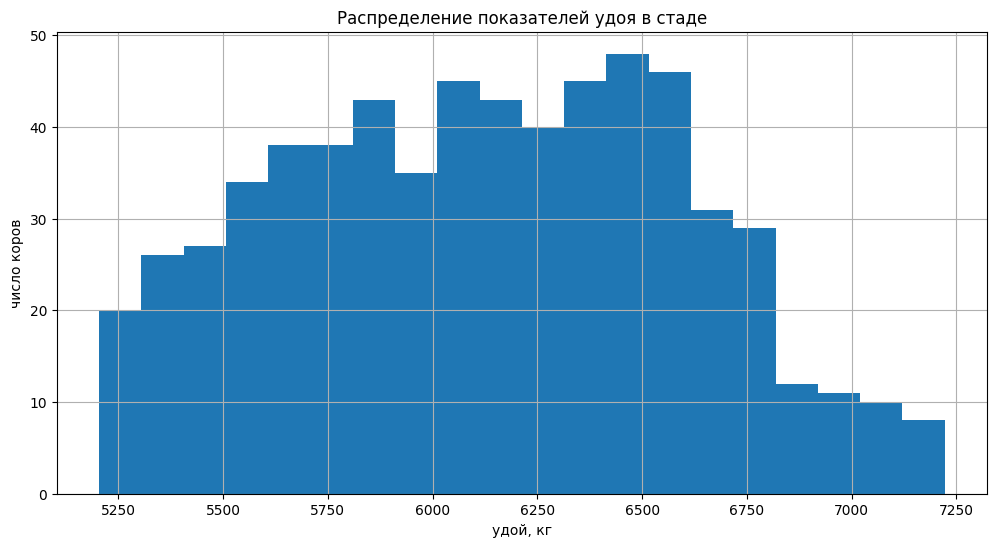

In [33]:
# Строим гистограмму для yield
data_ferma['yield'].hist(bins=20,figsize=(12,6))
plt.title('Распределение показателей удоя в стаде')
plt.xlabel('удой, кг')
plt.ylabel('число коров')
plt.show()

Теперь переменная yield очищена от выбросов, распределение выглядит правдоподобным.

3.2 Посмотрим распределение коров по породам в стаде.

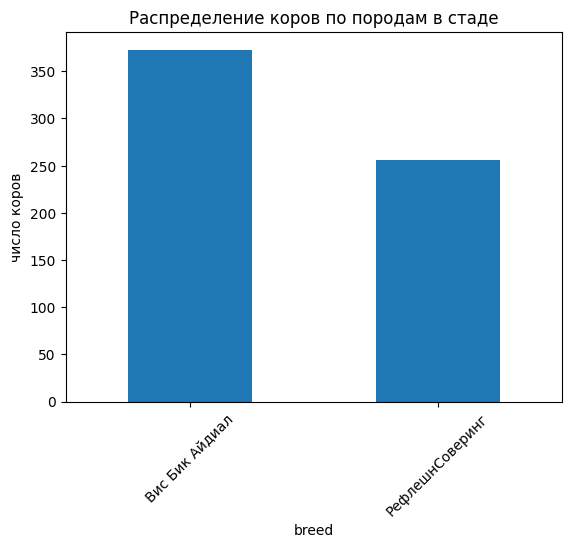

In [34]:
# Строим столбчатую диаграмму для breed
freqs = data_ferma['breed'].value_counts()

ax = freqs.plot.bar()

plt.title('Распределение коров по породам в стаде')
plt.ylabel('число коров')
plt.xticks(rotation=45)
plt.show()

Как видим, в стаде присутствуют всего две породы: Вис Бик Айдиал и РефлешнСоверинг, первой чуть боьше 350 голов, второй чуть больше 250.

Посмотрим породы пап.

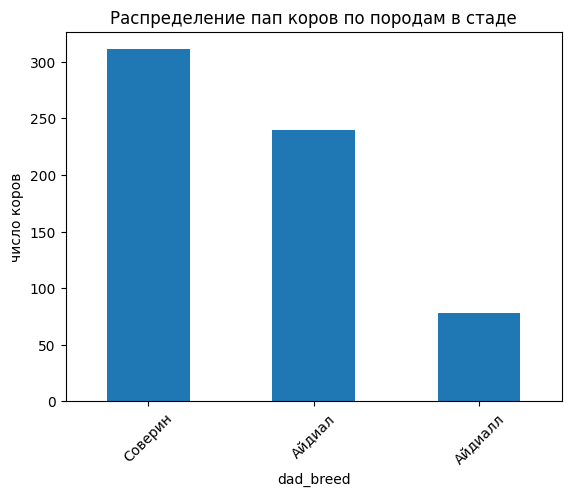

In [35]:
# Строим столбчатую диаграмму для dad_breed
freqs = data_ferma['dad_breed'].value_counts()

ax = freqs.plot.bar()

plt.title('Распределение пап коров по породам в стаде')
plt.ylabel('число коров')
plt.xticks(rotation=45)
plt.show()

Видно, в данных по породам пап оказались скрытые дубликаты.

Заменим "Айдиалл" на "Айдиал", как записано в породах коров.

In [36]:
data_ferma =data_ferma.replace('Айдиалл','Айдиал', regex=True)

Повторим столбчатую диаграмму для  dad_breed.

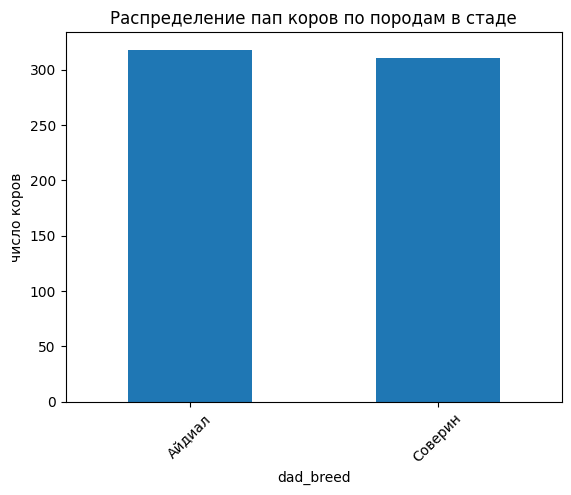

In [37]:
# Строим столбчатую диаграмму для dad_breed
freqs = data_ferma['dad_breed'].value_counts()

ax = freqs.plot.bar()

plt.title('Распределение пап коров по породам в стаде')
plt.ylabel('число коров')
plt.xticks(rotation=45)
plt.show()

Теперь породы пап коров оказались распределены практически поровну.

3.3 Проанализируем возраст коров в стаде. Построим круговую диаграмму.

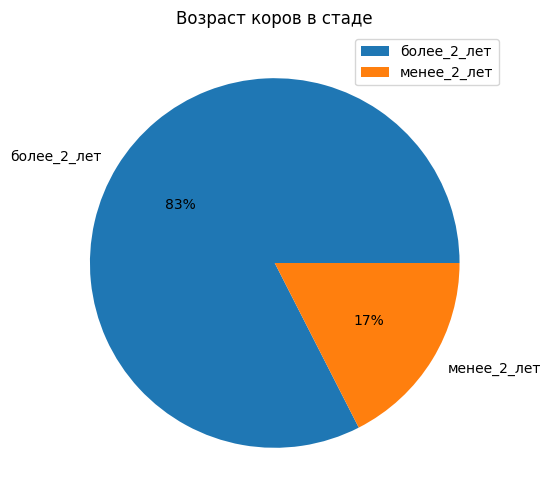

In [38]:
# Строим круговую диаграмму для age
data_ferma.pivot_table(index='age', values='id',aggfunc='count').plot(kind='pie',y='id',figsize=(12,6),label='',autopct='%1.0f%%')
plt.title('Возраст коров в стаде')
plt.show()


Подавляющее большинство коров в стаде (83%) старше 2 лет.

3.4 Проанализируем характеристики корма: ЭКЕ, сырой протеин и СПО.

Построим три гистограммы на одной картинке.

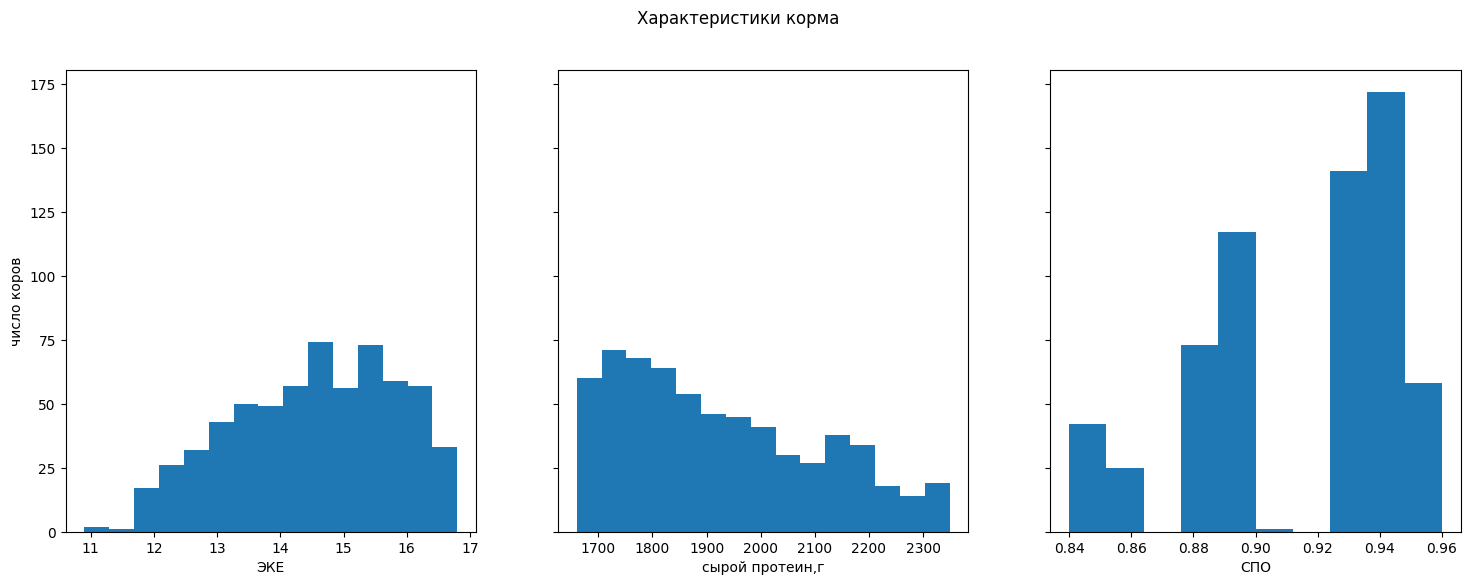

In [39]:
# Строим гистограммы для energy_feed_unit, protein_raw, sugar_protein
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axs[0].hist(data_ferma['energy_feed_unit'],bins=15)
axs[0].set_xlabel('ЭКЕ')
axs[0].set_ylabel('число коров')

axs[1].hist(data_ferma['protein_raw'],bins=15)
axs[1].set_xlabel('сырой протеин,г')

axs[2].hist(data_ferma['sugar_protein'],bins=10)
axs[2].set_xlabel('СПО')

fig.suptitle('Характеристики корма ')
plt.show()

Здесь выглядит странно третья гистограмма: пропущены значения 0,87 и 0,92. Посмотрим, какие в принципе значения принимает переменная СПО.  

In [40]:
data_ferma['sugar_protein'].sort_values().unique()

array([0.84 , 0.85 , 0.86 , 0.88 , 0.885, 0.89 , 0.895, 0.9  , 0.93 ,
       0.94 , 0.95 , 0.96 ])

Переменная СПО принимает значения от 0.84 до 0.96, причем с дискретным шагом 0.005.

В принципе, такое возможно, например, из-за точности приборов, которые измеряют сахар и протеин в корме коровы. Лучше было бы обратиться в "Экоферму" за консультацией, как получены значения СПО. Заменять данные не будем.

3.5 Рассмотрим типы пастбищ. Построим круговую диаграмму.

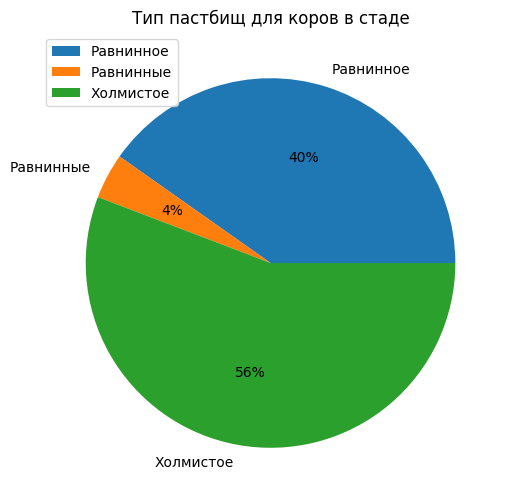

In [41]:
# Строим круговую диаграмму для pasture_type
data_ferma.pivot_table(index='pasture_type', values='id',aggfunc='count')\
.plot(kind='pie',y='id',figsize=(12,6),label='',autopct='%1.0f%%')
plt.title('Тип пастбищ для коров в стаде')
plt.show()

Опять у нас появились неявные дубликаты в данных, заменим "Равнинные" на "Равнинное" для единообразия с "Холмистое".

In [42]:
data_ferma =data_ferma.replace('Равнинные','Равнинное')

Снова построим круговую диаграмму.

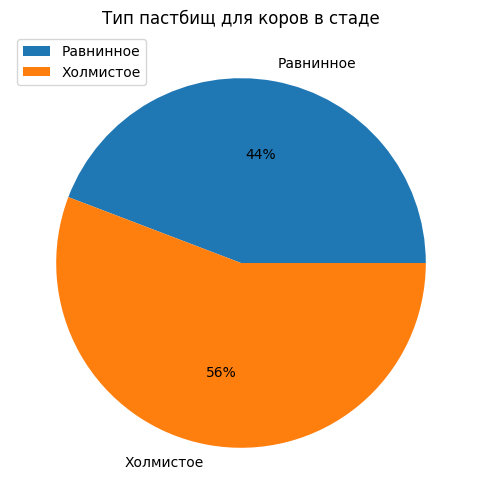

In [43]:
# Строим круговую диаграмму для pasture_type
data_ferma.pivot_table(index='pasture_type', values='id',aggfunc='count')\
.plot(kind='pie',y='id',figsize=(10,6),label='',autopct='%1.0f%%')
plt.title('Тип пастбищ для коров в стаде')
plt.show()

Холмистые пастбища немного преобладают над равнинными (56% против 44%)

3.6 Рассмотрим характеристики молока.

[Удой](#section3) мы уже рассмотрели в п. 3.1.

Для жирности и белка мы тоже строили гистограммы в п.3.1, посмотрим на них более подробно.

3.6.1 Построим гистограмму для жирности.

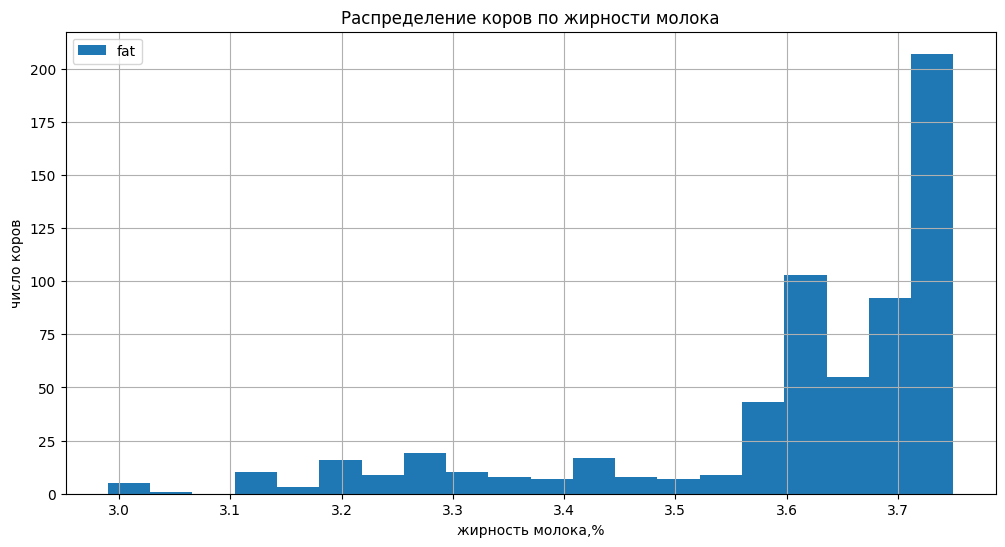

In [44]:
# Строим гистограмму для fat
data_ferma['fat'].hist(bins=20,figsize=(12,6),legend=True)
plt.title('Распределение коров по жирности молока')
plt.xlabel('жирность молока,%')
plt.ylabel('число коров')

plt.show()

Попробуем построить гистограммы для жирности с разным числом корзин: 25, 30, 35.

Text(0.5, 0.98, 'Гистограммы для жирности ')

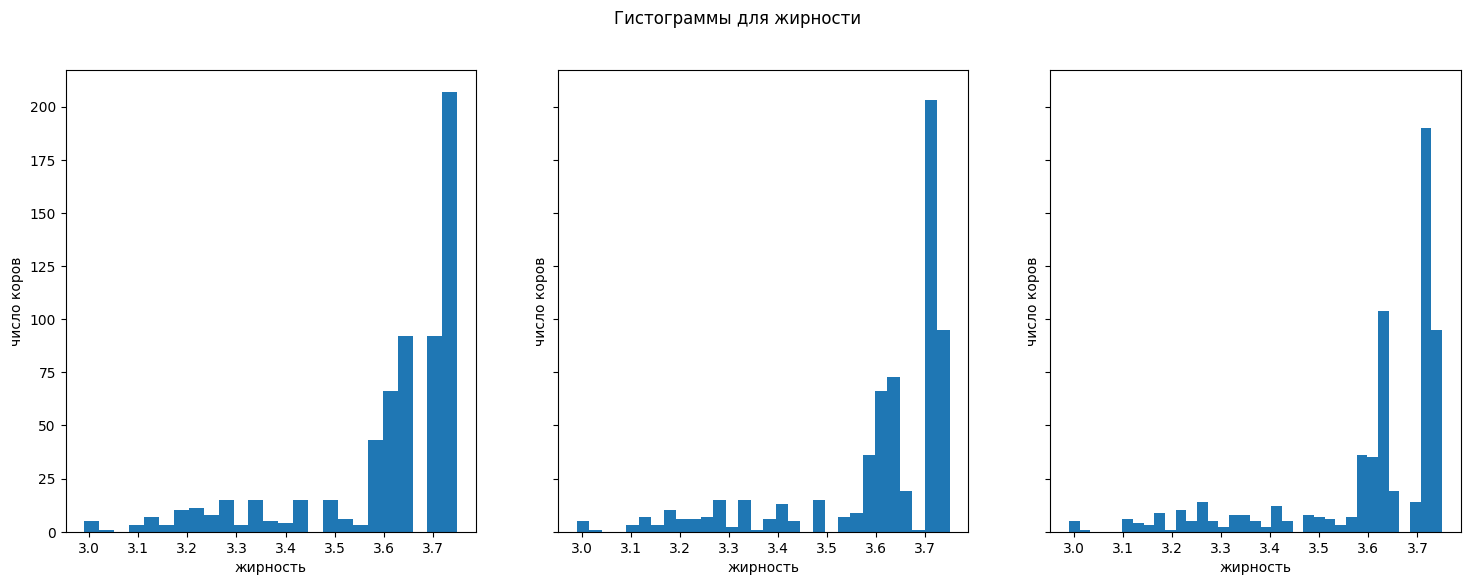

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axs[0].hist(data_ferma['fat'],bins=25)
axs[0].set_xlabel('жирность')
axs[0].set_ylabel('число коров')

axs[1].hist(data_ferma['fat'],bins=30)
axs[1].set_xlabel('жирность')
axs[1].set_ylabel('число коров')

axs[2].hist(data_ferma['fat'],bins=35)
axs[2].set_xlabel('жирность')
axs[2].set_ylabel('число коров')

fig.suptitle('Гистограммы для жирности ')

Правый край распределения выглядит неправдоподобно, жирность молока может принимать значения до 6% (по информации из открытых источников), данные выглядят неполными.

Странно, что есть много данных левее наиболее часто встречающегося значения, но совсем нет данных правее, как будто гистограмму "обрезали" по правому краю.

Выведем описательные статистики и построим "ящик с усами" для переменной жирности молока.

In [46]:
data_ferma['fat'].describe()

,fat
count,629.000000
mean,3.603657
std,0.168656
min,2.990000
25%,3.590000
50%,3.650000
75%,3.720000
max,3.750000


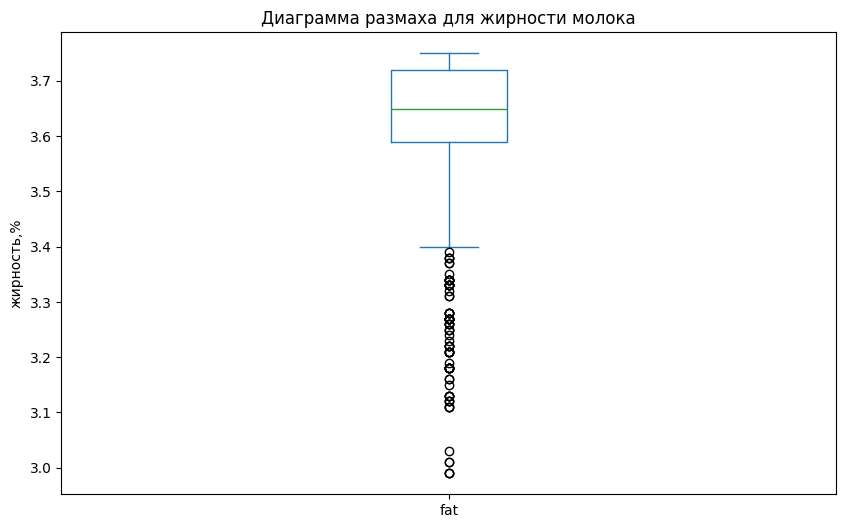

In [47]:
ax = data_ferma['fat'].plot.box(figsize=(10,6))
plt.title('Диаграмма размаха для жирности молока')
plt.ylabel('жирность,%')
plt.show()

Медианное значение 3.65, среднее 3.6, значит в данных много выбросов, которые смещают среднее влево от наиболее часто встречающегося значения, что подтверждается диаграммой размаха.

Вряд ли жирность молока имеет верхнюю границу 3.75%, возможно все значения выше просто записали в наиболее часто встречающееся 3.65%. В любом случае, данные выглядят подозрительно, следует проконсультироваться у "ЭкоФермы", как они были получены.

3.6.2 Теперь рассмотрим переменную количества белка в молоке.

Построим гистограмму для распределения коров по количеству белка в молоке.

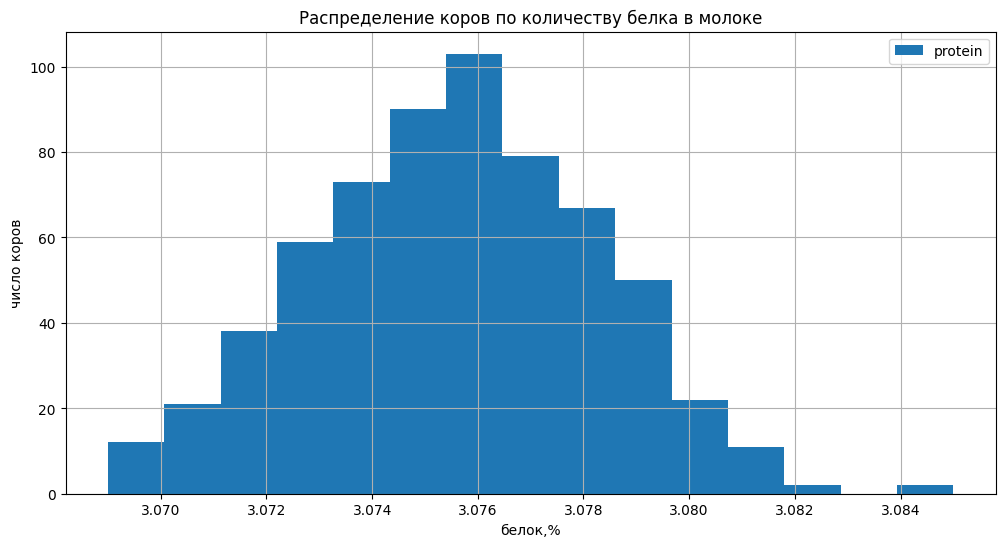

In [48]:
# Строим гистограмму для protein
data_ferma['protein'].hist(bins=15,figsize=(12,6),legend=True)
plt.title('Распределение коров по количеству белка в молоке')
plt.xlabel('белок,%')
plt.ylabel('число коров')
plt.show()

Здесь данные распределены симметрично относительно центра распределения.

Посмотрим на описательные статистики.

In [49]:
data_ferma['protein'].describe()

,protein
count,629.000000
mean,3.075671
std,0.002549
min,3.069000
25%,3.074000
50%,3.076000
75%,3.077000
max,3.085000


Среднее и медиана практически совпадают и равны 3.076, стандартное отклонение 0.003 очень маленькое.

Построим диаграмму размаха для количества белка в молоке.

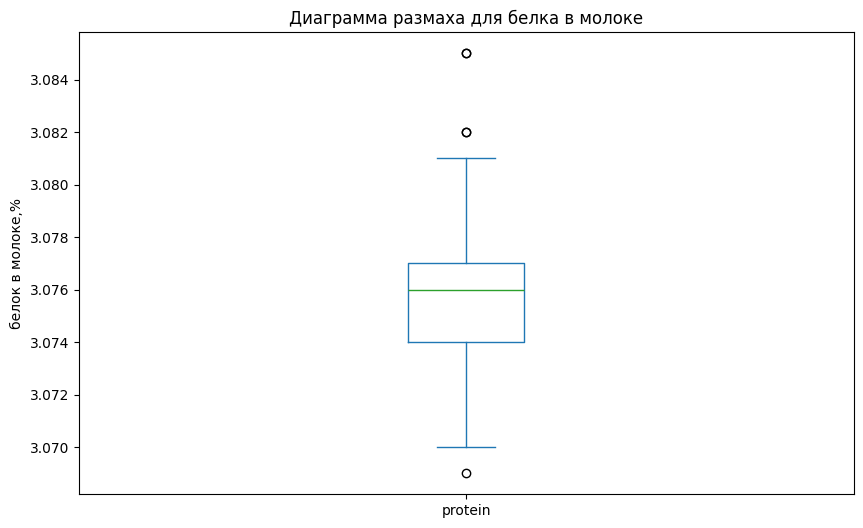

In [50]:
ax = data_ferma['protein'].plot.box(figsize=(10,6))
plt.title('Диаграмма размаха для белка в молоке')
plt.ylabel('белок в молоке,%')
plt.show()

В этих данных практически нет выбросов, в отличие от показателей жирности.

3.6.3 Вкус молока принимает всего два значения, для него уместно построить круговую диаграмму.

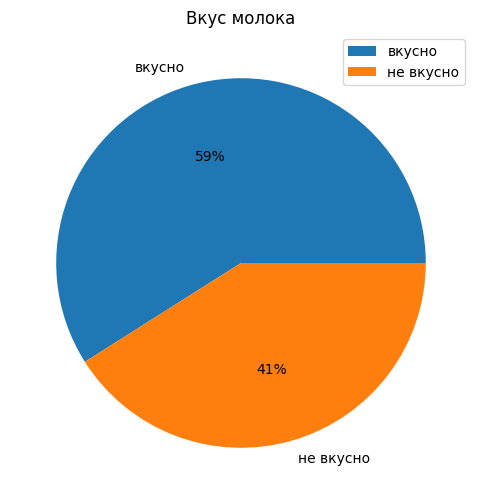

In [51]:
# Строим круговую диаграмму для pasture_type
data_ferma.pivot_table(index='taste', values='id',aggfunc='count')\
.plot(kind='pie',y='id',figsize=(10,6),label='',autopct='%1.0f%%')
plt.title('Вкус молока')
plt.show()

Итого, молоко вкусное у 59% коров, невкусное у 41%.

3.7 Для имени папы построим столбчатую диаграмму.

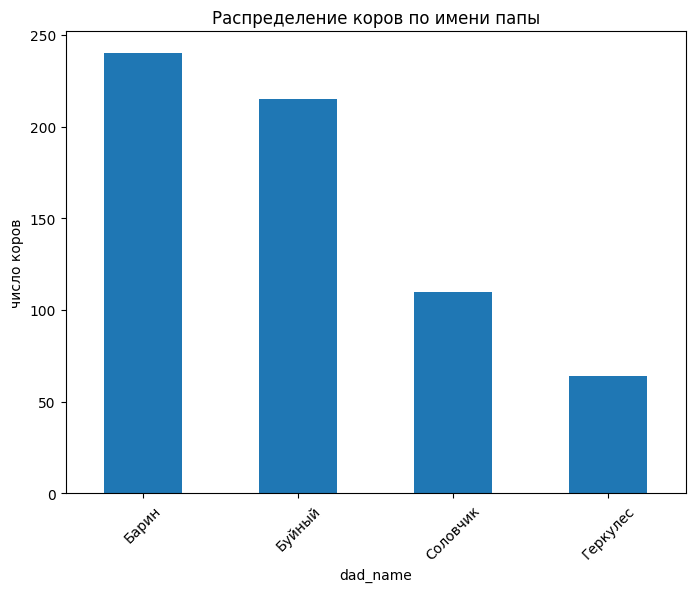

In [52]:
# Строим столбчатую диаграмму для dad_name
freqs = data_dad['dad_name'].value_counts()

ax = freqs.plot.bar(figsize=(8,6))

plt.title('Распределение коров по имени папы')
plt.ylabel('число коров')
plt.xticks(rotation=45)
plt.show()

Больше всего "детей" оказалось у Барина, затем у Буйного, потом у Соловчика, меньше всего у Геркулеса.

Таким образом, проведен исследовательский анализ данных.

Для всех категориальных переменных построены столбчатые диаграммы, для количественных гистограммы.

Выявлено и удалено аномальное значение в переменной "Удой".

Из количественных переменных вызывают подозрение данные по СПО (с дискретным шагом и пропущенными значениями) и данные по жирности молока (много значений левее медианного, и полное отсутствие значений правее).

Замен в данных не производилось.

<a id='section4'></a>
## Корреляционный анализ

4.1 Рассчитаем коэффициенты корреляции между всеми числовыми признаками и построим для них тепловую карту.

Используем коэффициенты корреляции Спирмана.

<Axes: >

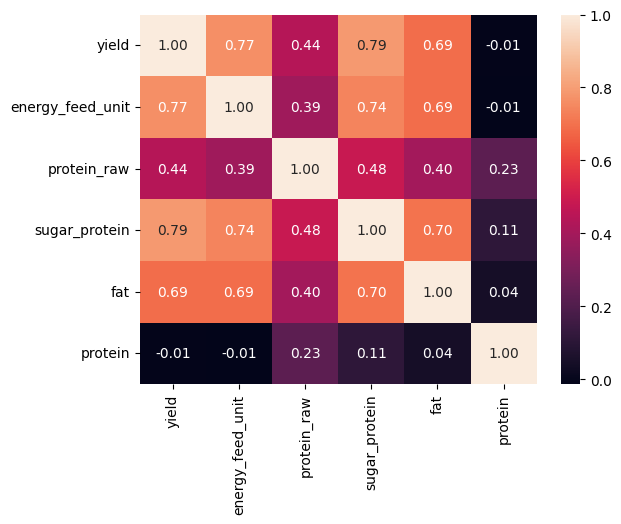

In [53]:
data_1=data_ferma.drop('id',axis=1)
sns.heatmap(data_1.corr(method='spearman',numeric_only=True), annot=True, fmt='.2f')

Самую большую корреляцию наблюдаем между удоем и СПО (0.8), удоем и ЭКЕ (0.76).

Между СПО и ЭКЕ закономерно тоже высокая корреляция (0.74).

Жирность заметно коррелирует с ЭКЕ (0.64) и СПО (0.62), а также с удоем (0.6).

Умеренная связь наблюдается между сырым протеином и удоем (0.45), СПО (0.45), ЭКЕ (0.39), жирностью (0.36).

Белок в молоке не коррелирует ни с одним признаком, кроме сырого протеина в корме, и то корреляция очень слабая (0.23).


<a id='section6'></a>4.2 Построим диаграммы рассеяния для удоя с различными количественными признаками с учетом значения категориальных признаков (типа пастбища, возраста, породы папы).

Цвет точек диаграммы отображает признак "порода": синие точки для породы Вис Бик Айдиал, оранжевые - для РефлешнСоверинг.

Напишем функцию для построения диаграммы рассеяния для двух признаков с разделением данных по категориальному признаку.

In [54]:
# Функция для построения диаграммы рассеяния параметров x_0 и y_0 с разбивкой по параметру col_0
def scatterplot (x_0,y_0,col_0):
    sns.relplot(
    x=x_0,
    y=y_0,
    data=data_ferma,
    palette='bright',
    col=col_0,
    hue='breed');

<a id='section6'></a> 4.2.1 С помощью этой функции построим диаграммы рассеяния для удоя и СПО.

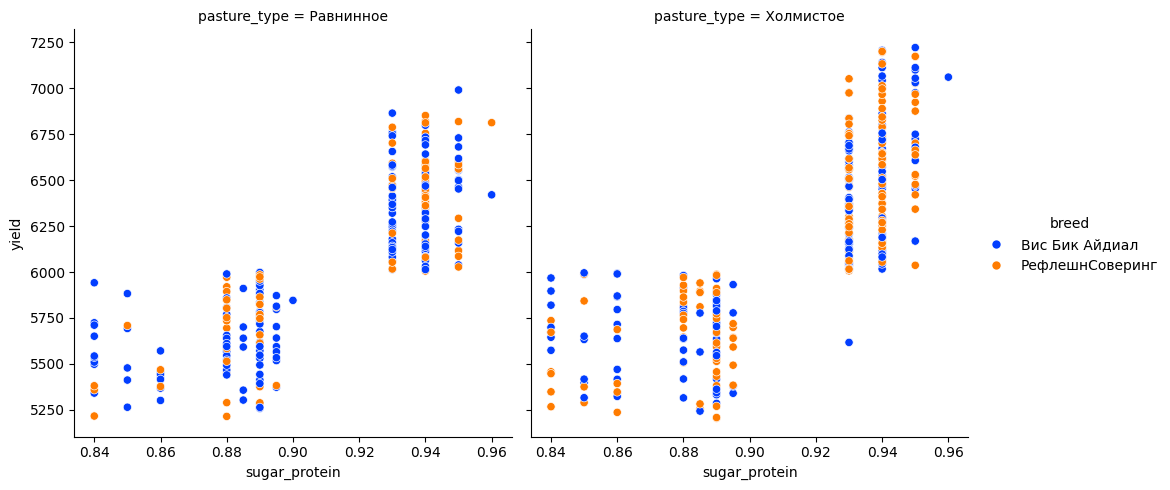

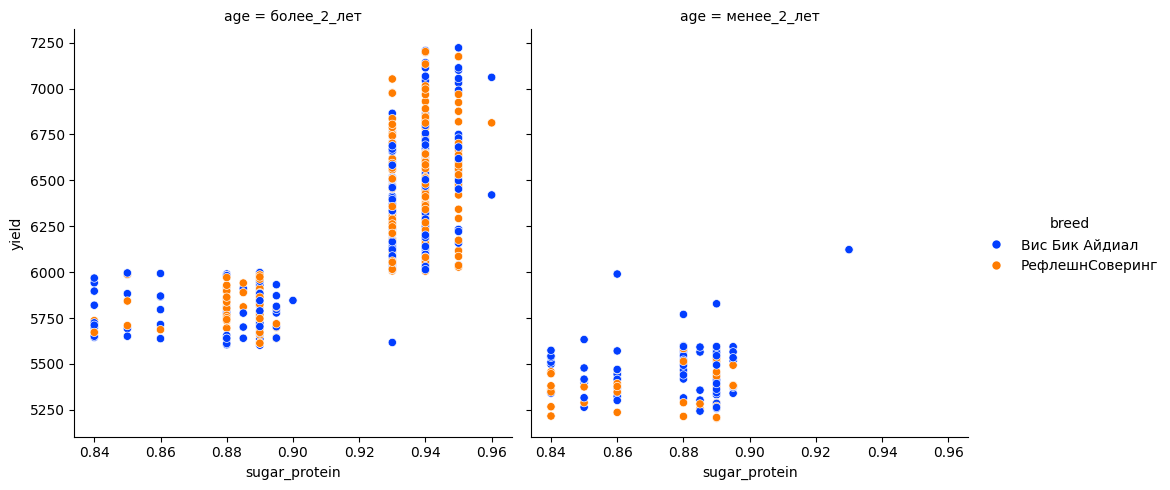

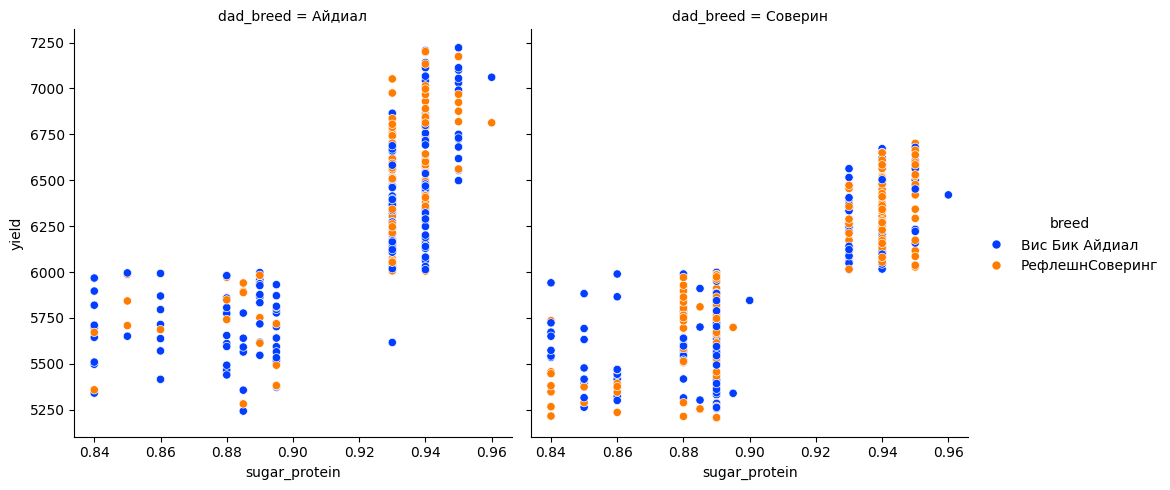

In [55]:
scatterplot('sugar_protein','yield','pasture_type')
scatterplot('sugar_protein','yield','age')
scatterplot('sugar_protein','yield','dad_breed')

Из построенных диаграмм видно, что данные по удою в зависимости от СПО разделяются на два кластера, и очень четко видна граница между этими кластерами СПО = 0.9. Если СПО меньше 0.9, то удой не превышает 6000 кг независимо от любых категориальных признаков, если больше 0.9, то удой больше 6000 кг.

В каждом из этих кластеров не видно линейной связи между удоем и СПО.

4.2.2  Теперь проделаем то же самое для другого сильно коррелирующего с удоем признака: ЭКЕ корма.

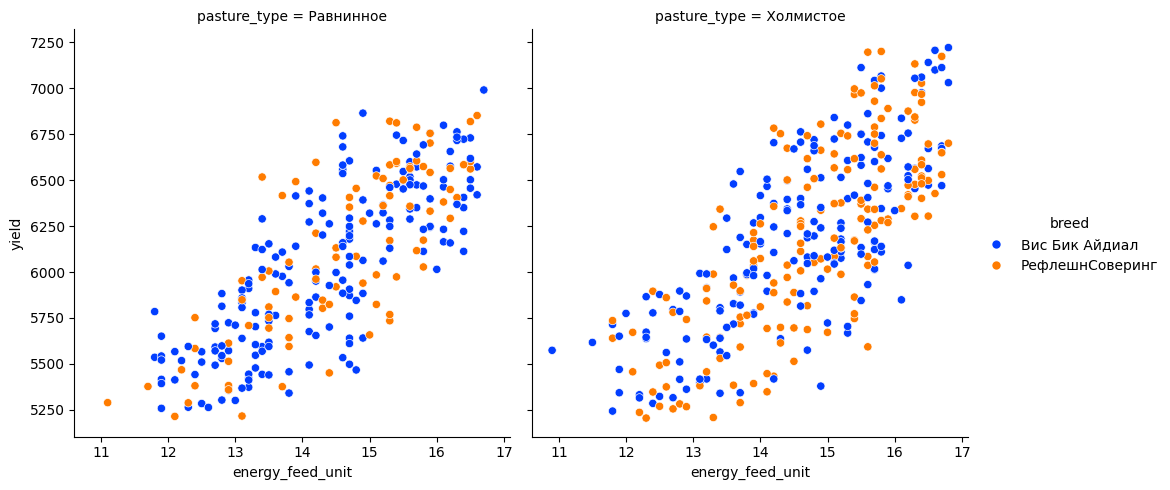

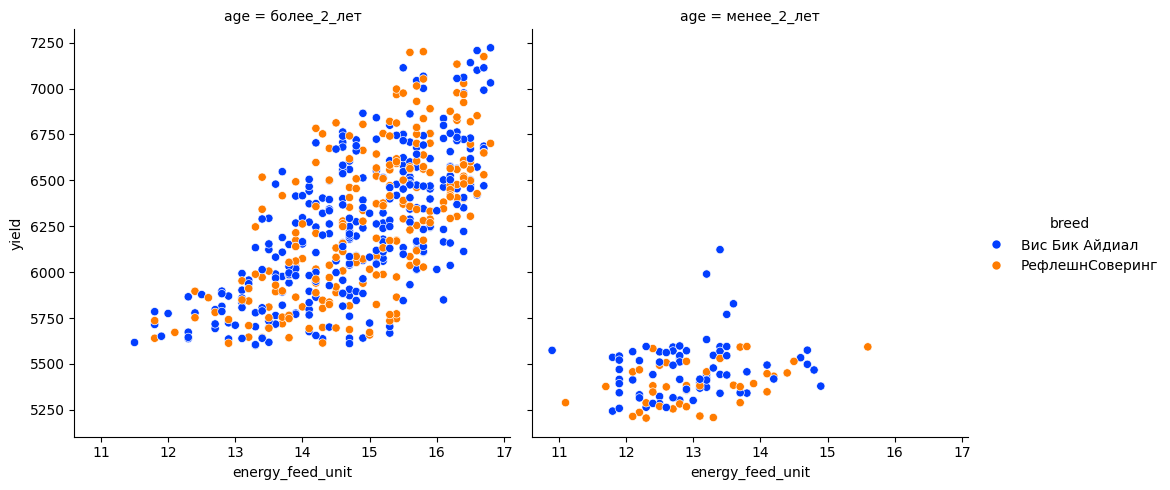

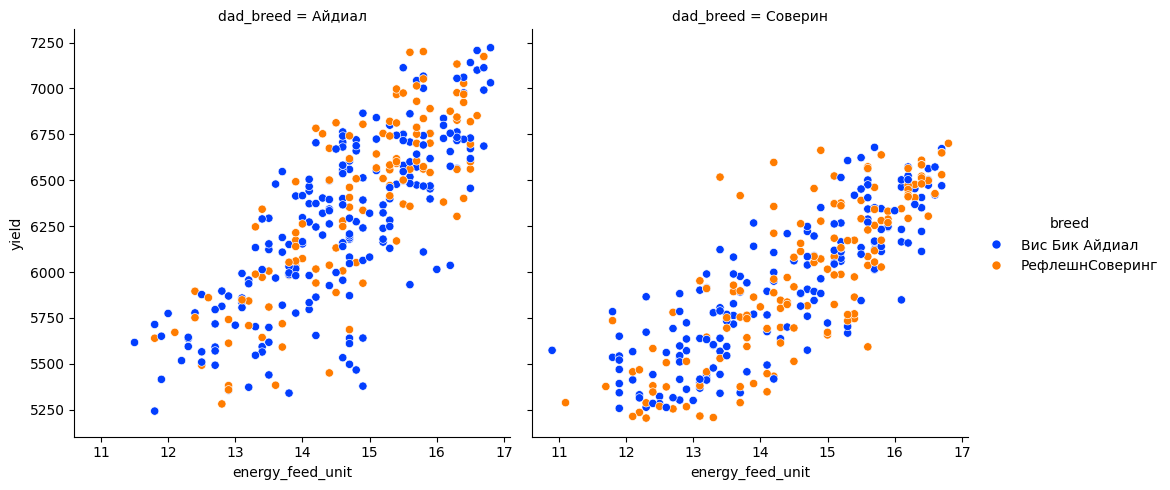

In [56]:
scatterplot('energy_feed_unit','yield','pasture_type')
scatterplot('energy_feed_unit','yield','age')
scatterplot('energy_feed_unit','yield','dad_breed')

На этих диаграммах прослеживается линейная связь (с большим разбросом вокруг предполагаемой прямой) удоя и ЭКЕ  корма, кроме молодых коров (до 2 лет).

Если сильно присмотеться, можно предположить, что зависимость удой - ЕКЭ является больше квадратичной, чем линейной (особенно это заметно на взрослых коровах и на тех, кто пасется на холмистых пастбищах.

4.2.3 Те же диаграммы рассеяния построим для связи удой - жирность молока.

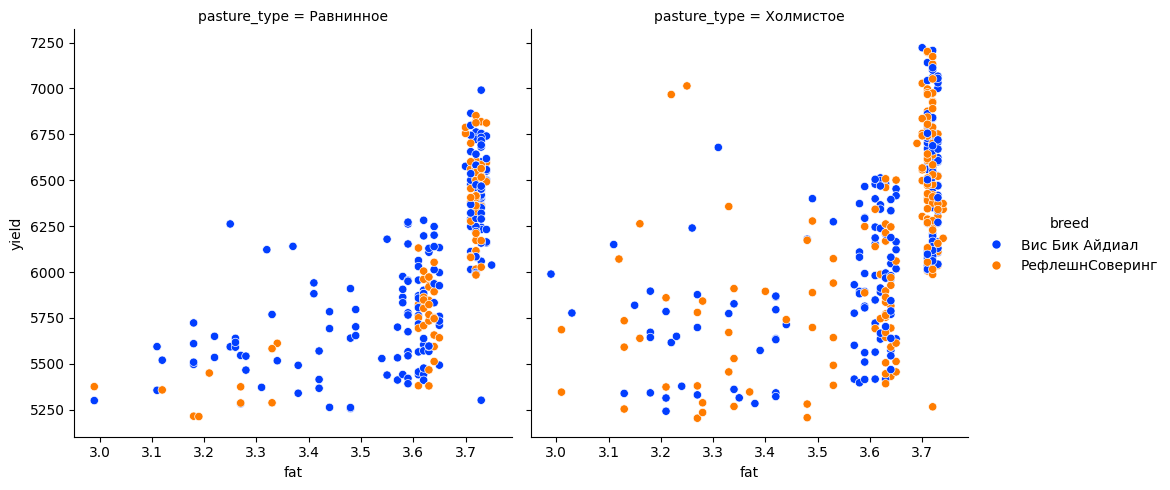

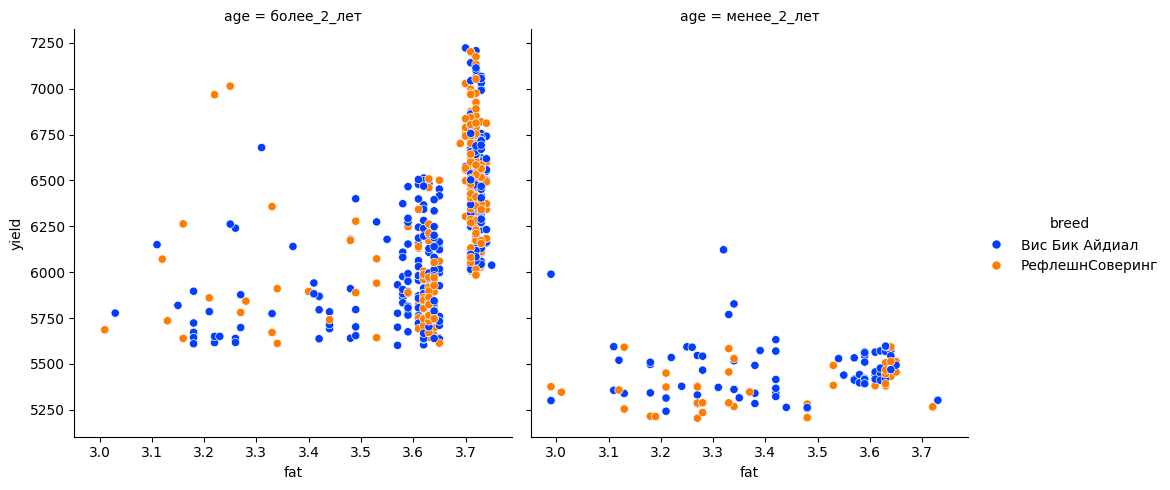

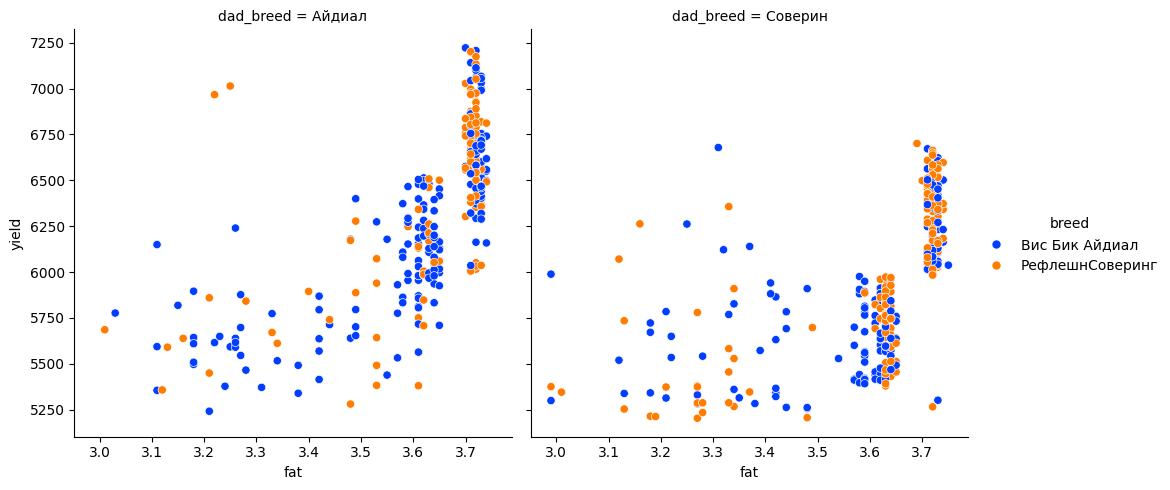

In [57]:
scatterplot('fat','yield','pasture_type')
scatterplot('fat','yield','age')
scatterplot('fat','yield','dad_breed')

Здесь тоже не видно линейной связи, но это скорее  связано со структурой данных по жирности: абсолютное большинство значений жирности 3.65, и есть много выбросов меньше этого значения.   

В то же время отчетливо видно, что большей жирности соответствует больший удой (кроме молодых коров).

4.2.4 Последней  отобразим связь удоя и сырого протеина в корме.

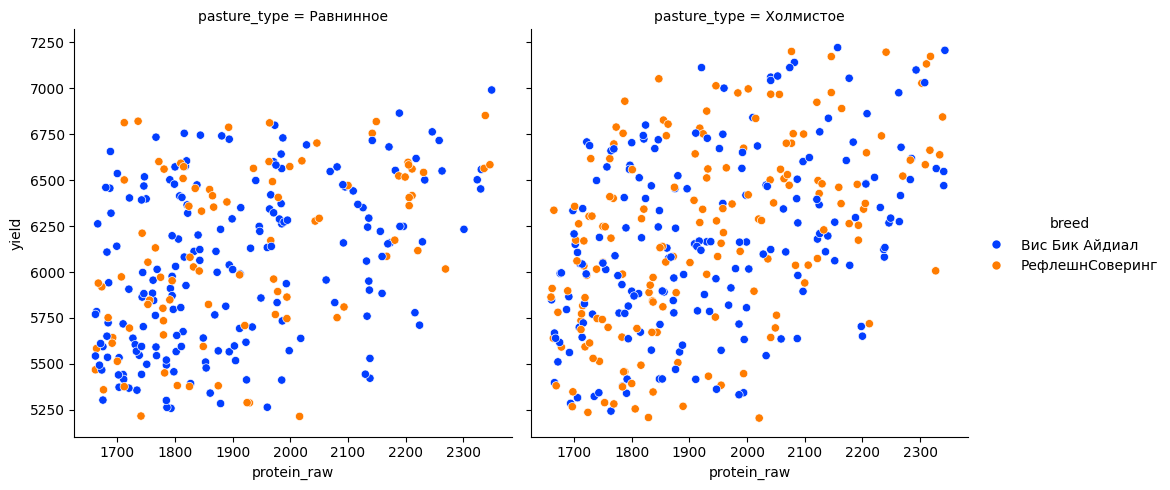

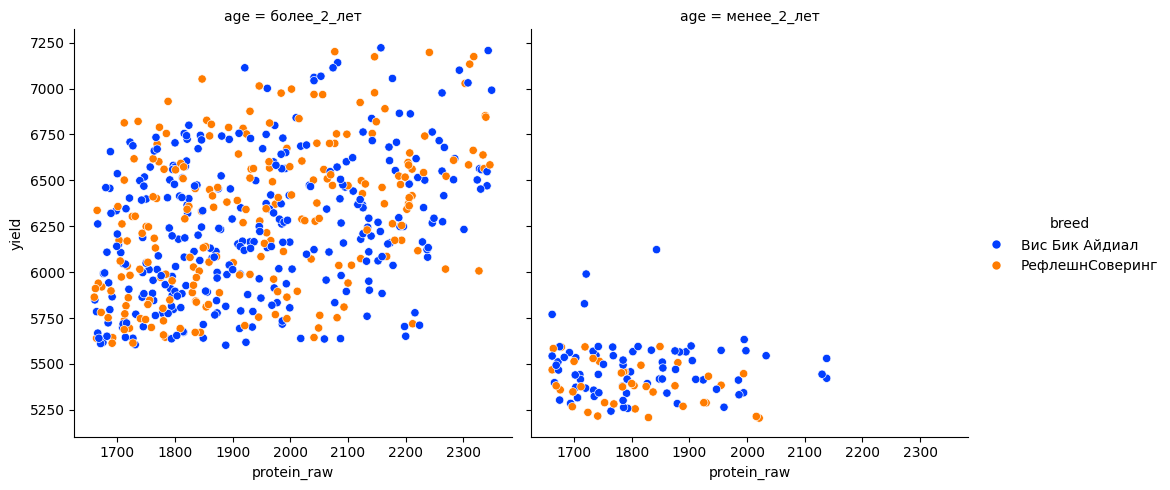

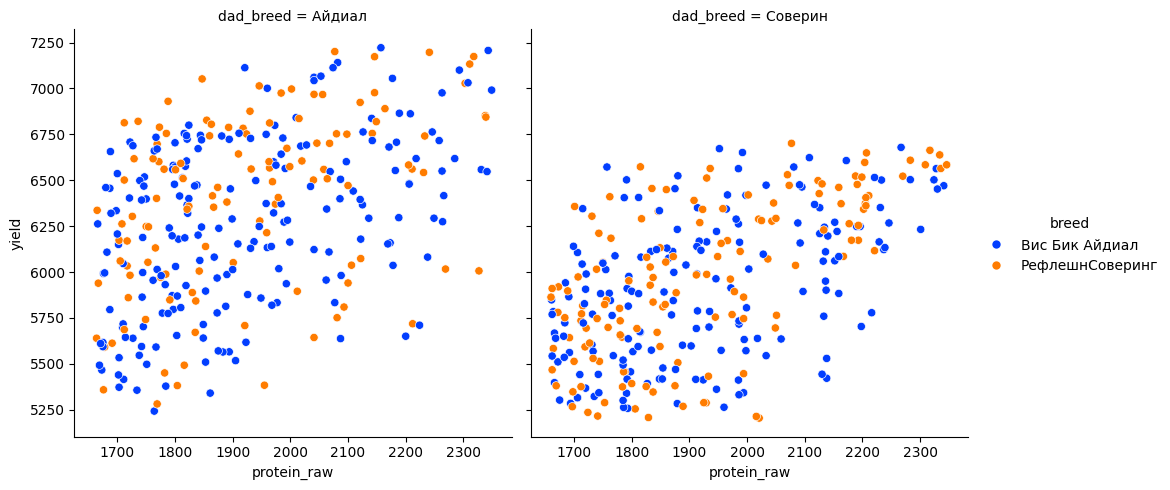

In [58]:
scatterplot('protein_raw','yield','pasture_type')
scatterplot('protein_raw','yield','age')
scatterplot('protein_raw','yield','dad_breed')

Здесь на диаграммах не прослеживается никакой линейной связи между удоем и сырым протеином в корме.

Белок в молоке не коррелирует с удоем, поэтому для него строить диаграммы нет смысла, никакой линейной связи между ними нет.

<a id='section8'></a>
4.2.5 Можно рассчитать еще коэффициенты корреляции Фи средствами библиотеки phik, чтобы оценить  взаимосвязь между удоем и категориальными признаками.

In [59]:
data_ferma.drop('id',axis=1).phik_matrix(interval_cols=
                   ['yield', 'energy_feed_unit', 'protein_raw',
                    'sugar_protein', 'fat', 'protein']
                  ).style.background_gradient(cmap="RdYlGn")

,yield,energy_feed_unit,protein_raw,sugar_protein,breed,pasture_type,dad_breed,fat,protein,taste,age
yield,1.000000,0.721540,0.465193,0.660030,0.164966,0.278992,0.518217,0.707379,0.056292,0.174385,0.998102
energy_feed_unit,0.721540,1.000000,0.459653,0.589307,0.129219,0.103065,0.166325,0.717846,0.000000,0.271287,0.768438
protein_raw,0.465193,0.459653,1.000000,0.386521,0.090792,0.095991,0.000000,0.401195,0.204030,0.174024,0.349587
sugar_protein,0.660030,0.589307,0.386521,1.000000,0.064396,0.158532,0.427779,0.644730,0.074004,0.569538,0.744653
breed,0.164966,0.129219,0.090792,0.064396,1.000000,0.211084,0.091673,0.223584,0.361880,0.000000,0.055837
pasture_type,0.278992,0.103065,0.095991,0.158532,0.211084,1.000000,0.000000,0.000000,0.101419,0.270583,0.129482
dad_breed,0.518217,0.166325,0.000000,0.427779,0.091673,0.000000,1.000000,0.000000,0.132270,0.000000,0.356573
fat,0.707379,0.717846,0.401195,0.644730,0.223584,0.000000,0.000000,1.000000,0.000000,0.198952,0.674410
protein,0.056292,0.000000,0.204030,0.074004,0.361880,0.101419,0.132270,0.000000,1.000000,0.145850,0.000000
taste,0.174385,0.271287,0.174024,0.569538,0.000000,0.270583,0.000000,0.198952,0.145850,1.000000,0.166869


Как видим, удой очень сильно коррелирует с возрастом коровы (коэфф.корреляции 0.99), умеренная связь наблюдается с породой папы (0.52), и слабая связь наблюдается с породой (0.17), вкусом молока (0.18) и с типом пастбища (0.28)

4.3 Таким образом, по диаграммам рассеяния четкая линейная связь между целевым признаком (удой) и входными признаками прослеживается только для ЭКЕ.

Нелинейная связь видна для отношения удой-СПО и удой-жирность.

Никакой связи не видно для отношения удой-сырой протеин.

Поскольку о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95, то между входными признаками нет мультиколлинеарности, самый большой коэффициент корреляции среди входных признаков наблюдается между СПО и ЭКЕ: 0.74.

По категориальным признакам очень сильная связь прослеживается с возрастом коровы, умеренная связь с породой папы, со всеми остальными категориальными признаками связь слабая.

На всех диаграммах для породы папы Айдиал удой больше, чем для породы папы Соверин.

<a id='section5'></a>
## Обучение модели линейной регрессии

5.1 Подготовим данные датасета ferma_main.csv и обучим на них первую модель  LinearRegression.

Целевой признак модели - удой молока, кг.

В качестве входных признаков отберем

<b>количественные признаки :</b> ЭКЕ, СПО, сырой протеин (характеристики корма),

<b>категориальные признаки :</b> возраст, порода, порода папы, тип пастбища.
</div>

Разобьем данные на тренировочную и тестовые выборки.

In [60]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42

#список признаков, которые не являются входными
s=['yield','id','protein','taste','fat']

X = data_ferma.drop(s, axis=1)
y = data_ferma['yield']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

Проверим тренировочную выборку.

In [61]:
display(X_train.head(5))

,energy_feed_unit,protein_raw,sugar_protein,breed,pasture_type,dad_breed,age
612,14.6,1967,0.94,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
587,14.7,1671,0.88,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
196,14.6,2125,0.93,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет
328,13.1,2077,0.89,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
259,15.3,1801,0.93,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет


Кодируем категориальные признаки.

In [62]:
# список категориальных переменных
cat_col_names = ['breed','pasture_type','dad_breed','age',]

# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse_output=False)

# обучение и кодирование тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# кодирование тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names])

# список новых столбцов
encoder_col_names = encoder.get_feature_names_out()

# создание датафрейма из закодированных данных
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)

# создание тренировочного и тестового датафрейма из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# пять первых строк из датафрейма
print(df_ohe.head(5))

   breed_РефлешнСоверинг  pasture_type_Холмистое  dad_breed_Соверин  \
0                    0.0                     0.0                0.0   
1                    0.0                     0.0                0.0   
2                    0.0                     1.0                0.0   
3                    0.0                     0.0                0.0   
4                    1.0                     1.0                0.0   

   age_менее_2_лет  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


Масштабируем количественные признаки.

In [63]:
#список количественных признаков
num_col_names = ['energy_feed_unit','sugar_protein','protein_raw']

# выбор метода масштабирования
scaler = StandardScaler()

# настройка и масштабирование тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# масштабирование тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# создание тренировочного и тестового датафрейма из масштабированных данных
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

Объединим подготовленные количественные и категориальные данные в один DataFrame.

In [64]:
# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# выводим пять первых строк из тренировочного датафрейма
print(X_train.head(5))

   breed_РефлешнСоверинг  pasture_type_Холмистое  dad_breed_Соверин  \
0                    0.0                     0.0                0.0   
1                    0.0                     0.0                0.0   
2                    0.0                     1.0                0.0   
3                    0.0                     0.0                0.0   
4                    1.0                     1.0                0.0   

   age_менее_2_лет  energy_feed_unit  sugar_protein  protein_raw  
0              0.0          0.016344       0.814135     0.248479  
1              0.0          0.095707      -1.072496    -1.392310  
2              0.0          0.016344       0.499697     1.124306  
3              0.0         -1.174092      -0.758057     0.858232  
4              0.0          0.571881       0.499697    -0.671693  


Посмотрим на распределение количественных признаков после масштабирования.

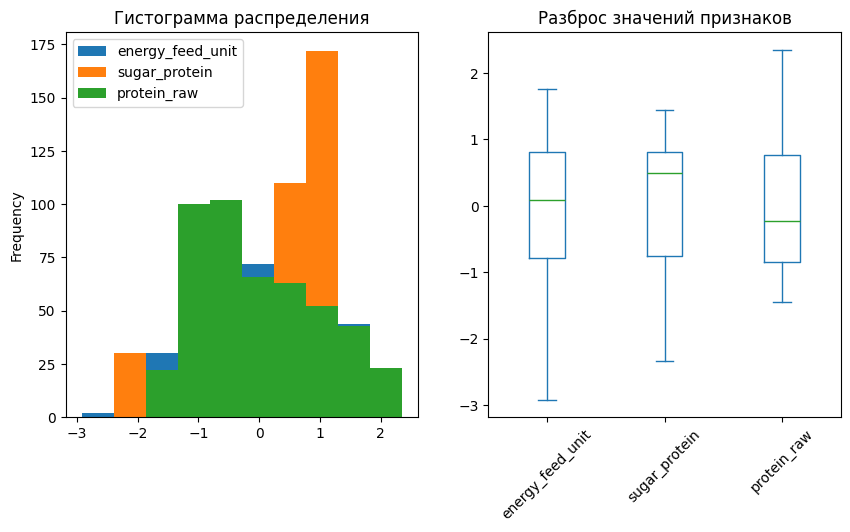

In [65]:
# графики по количественным признакам тренировочного датасета:
# гистограмма частотности распределения и ящик с усами.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

Теперь все количественные признаки в основном сосредоточены в промежутке (-1,1).

Обучим модель линейной регрессии на подготовленных данных.

In [66]:
# инициализация модели
model_lr  = LinearRegression()

# обучение модели на тренировочных данных
model_lr.fit(X_train, y_train)

# вывод рассчитанных коэффициентов
print(model_lr.coef_,model_lr.intercept_)

# предсказанные значения для X_test
predictions = model_lr.predict(X_test)

[  32.58809764   55.97299713 -234.56157341 -209.89585694  146.33430638
  171.35385373   43.07701979] 6239.339198863228


Оценим качество модели на тестовой выборке.

Рассчитаем R^2.

In [67]:
# R2 для линейной регрессии
r2 = r2_score(y_test, predictions)

print(r2)

0.8194608020428206


R^2 получилось 0.82.

Рассчитаем три метрики mae, mse, rmse для оценки качества модели и последующего сравнения.

In [68]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse =root_mean_squared_error(y_test, predictions)

Проанализируем остатки с помощью графиков.

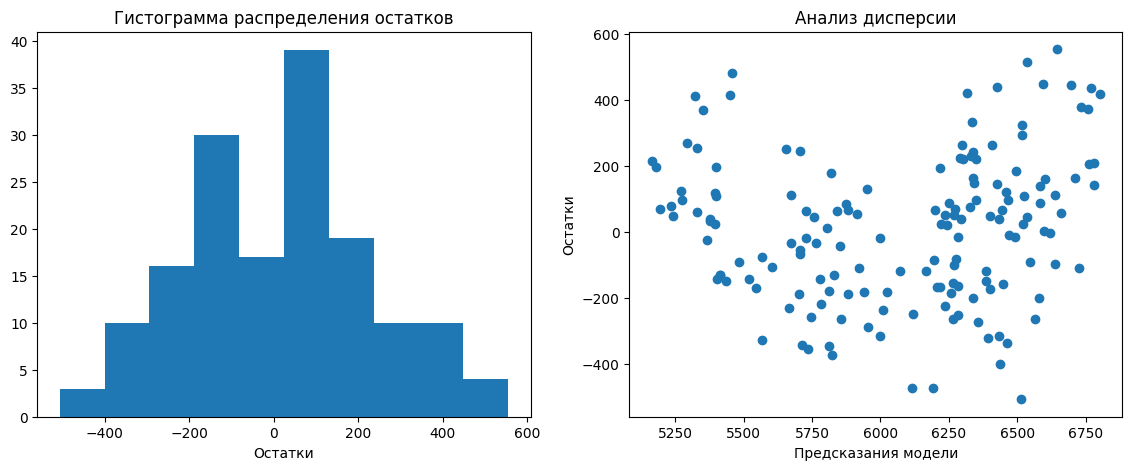

In [69]:
# остатки
residuals = y_test-predictions

# построение гистограммы частотности и диаграмму рассеяния остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

По гистограмме видно, что остатки не симметрично распределены относительно нуля: основная масса предсказанных значений имеет отрицательные остатки, в то же время положительные остатки имеют границу 600 кг, а отрицательные остатки доходят только до 400 кг, то есть остатки имеют выбросы.

Диаграмма рассеяния говорит о непостоянной дисперсии остатков: для прогнозных значений около 5800 кг разброс остатков около 400 кг, для прогнозных значений  6500 кг разброс остатков 800 кг, то есть в два раза больше.

Видимо, дело в нелинейной связи целевого и какого-то входного признака.

Или дело в данных по жирности, которые сами по себе несимметричны, и поэтому сдвигают остатки.

Следовательно, наша модель не вполне пригодна к использованию.

Нужно провести преобразование исходных данных.

По диаграмме рассеяния видно, что для меньших значений прогнозов ошибка меньше, чем для больших.
    
Кроме того, для значений прогноза 5200-5300 почти нет отрицательных ошибок, следовательно модель завышает значения маленьких  удоев.

5.2 Подготовим исходные данные с учетом выявленных проблем.

В [п.4.2.1](#section6), где мы строили  диаграммы рассеяния между удоем и СПО, мы заметили, что данные по удою в зависимости от СПО разделяются на два кластера с очень четкой границей СПО = 0.9, причем в обоих кластерах зависимость удоя от СПО не выглядит линейной.

Преобразуем СПО в категориальный бинарный признак.

In [70]:
data_ferma['sugar_protein_bin']=data_ferma['sugar_protein']>0.9

Попробуем ввести новый признак ЭКЕ в квадрате.

In [71]:
data_ferma['energy_feed_unit_squared']=data_ferma['energy_feed_unit']*data_ferma['energy_feed_unit']

Проверим корректность новых признаков.

In [72]:
display(data_ferma.head(5))

,id,yield,energy_feed_unit,protein_raw,sugar_protein,breed,pasture_type,dad_breed,fat,protein,taste,age,sugar_protein_bin,energy_feed_unit_squared
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,False,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,False,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,False,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,False,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,False,163.84


Признаки добавлены корректно.

Создадим вторую модель, используя эти признаки.

In [73]:
#список признаков, которые не являются входными
s=['yield','id','protein','taste','energy_feed_unit','sugar_protein','fat']

X = data_ferma.drop(s, axis=1)
y = data_ferma['yield']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)
# список категориальных переменных
cat_col_names = ['breed','pasture_type','dad_breed','age','sugar_protein_bin']

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

#список количественных признаков
num_col_names = ['energy_feed_unit_squared','protein_raw']

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model_lr_2  = LinearRegression()
model_lr_2.fit(X_train, y_train)
print(model_lr_2.coef_,model_lr_2.intercept_)
predictions = model_lr_2.predict(X_test)

r2 = r2_score(y_test, predictions)

mae_2 = mean_absolute_error(y_test, predictions)
mse_2 = mean_squared_error(y_test, predictions)
rmse_2 = root_mean_squared_error(y_test, predictions)


print(r2)

[  34.275076     37.0627734  -201.96762303 -220.5601869   392.06981384
  140.85455864   42.79138323] 5998.197273359601
0.8440612517381652


R^2 получилось 0.84, чуть лучше, чем в первый раз.

Проверим остатки.

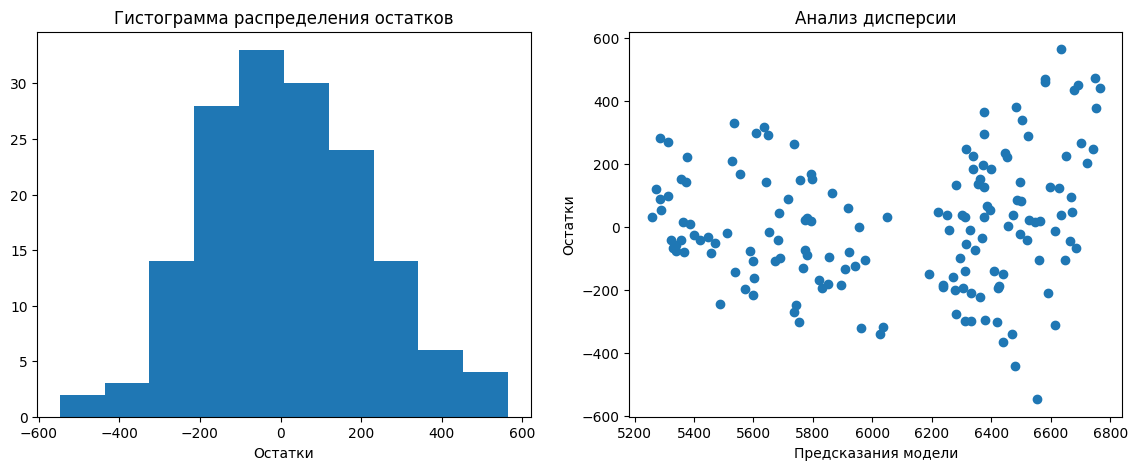

In [74]:
# остатки
residuals = y_test-predictions

# построение гистограммы частотности и диаграмму рассеяния остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма распределения остатков выглядит лучше, чем в первой модели - более симметрично относительно нуля, хотя правая граница все-таки больше, чем левая.

Диаграмма рассеяния снова выглядит неравномерно: для предсказаний в районе 5400 кг размах остатков составляет 400 кг, для предсказаний в районе 6600 кг размах остатков порядка 800 кг, то есть модель снова неудовлетворительна.

Здесь снова видно, что для меньших значений прогнозов по удою ошибка меньше, чем для больших.

5.3 Добавим в данные еще один признак: породу папы из второго датафрейма data_dad.

In [75]:
#объединяем датафреймы data_ferma и data_dad по id
data_ferma=data_ferma.merge(data_dad, on='id')

Построим тепловую карту корреляций между всеми признаками средствами библиотеки phik.

In [76]:
data_1=data_ferma.drop('id',axis=1)
data_1.phik_matrix(interval_cols=
                   ['yield', 'energy_feed_unit', 'protein_raw',
                    'sugar_protein', 'fat', 'protein', 'energy_feed_unit_squared']
                  ).style.background_gradient(cmap="RdYlGn")

,yield,energy_feed_unit,protein_raw,sugar_protein,breed,pasture_type,dad_breed,fat,protein,taste,age,sugar_protein_bin,energy_feed_unit_squared,dad_name
yield,1.000000,0.721540,0.465193,0.660030,0.164966,0.278992,0.518217,0.707379,0.056292,0.174385,0.998102,0.999881,0.720986,0.432232
energy_feed_unit,0.721540,1.000000,0.459653,0.589307,0.129219,0.103065,0.166325,0.717846,0.000000,0.271287,0.768438,0.897172,0.975144,0.061485
protein_raw,0.465193,0.459653,1.000000,0.386521,0.090792,0.095991,0.000000,0.401195,0.204030,0.174024,0.349587,0.533384,0.448788,0.110088
sugar_protein,0.660030,0.589307,0.386521,1.000000,0.064396,0.158532,0.427779,0.644730,0.074004,0.569538,0.744653,1.000000,0.582682,0.410347
breed,0.164966,0.129219,0.090792,0.064396,1.000000,0.211084,0.091673,0.223584,0.361880,0.000000,0.055837,0.024440,0.074692,0.382473
pasture_type,0.278992,0.103065,0.095991,0.158532,0.211084,1.000000,0.000000,0.000000,0.101419,0.270583,0.129482,0.144848,0.149239,0.233499
dad_breed,0.518217,0.166325,0.000000,0.427779,0.091673,0.000000,1.000000,0.000000,0.132270,0.000000,0.356573,0.409186,0.136051,0.982965
fat,0.707379,0.717846,0.401195,0.644730,0.223584,0.000000,0.000000,1.000000,0.000000,0.198952,0.674410,0.920379,0.712768,0.091743
protein,0.056292,0.000000,0.204030,0.074004,0.361880,0.101419,0.132270,0.000000,1.000000,0.145850,0.000000,0.000000,0.000000,0.087271
taste,0.174385,0.271287,0.174024,0.569538,0.000000,0.270583,0.000000,0.198952,0.145850,1.000000,0.166869,0.102858,0.305649,0.000000


Коэффициент корреляции Фи между удоем и именем папы равна 0.43.

Имя папы принимает 4 значения, добавим его в категориальные признаки.

С учетом очень высокого коэффициента корреляции Фи между именем папы и породой папы (0.98), исключим породу папы из списка категориальных переменных, чтобы избежать мультиколлинеарности.


Создадим третью модель и оценим ее качество.

In [77]:
#список признаков, которые не являются входными
s=['yield','id','protein','taste','energy_feed_unit','sugar_protein','fat','dad_breed']

X = data_ferma.drop(s, axis=1)
y = data_ferma['yield']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)
X_train['pasture_type']=X_train['pasture_type'].str.lower()
X_test['pasture_type']=X_test['pasture_type'].str.lower()
X_1=X_train.copy()#копия для дальнейшенго преобразования data_cow
# список категориальных переменных
cat_col_names = ['age','breed','pasture_type','sugar_protein_bin','dad_name']


encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

#список количественных признаков
num_col_names = ['energy_feed_unit_squared','protein_raw']

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model_lr_3  = LinearRegression()
model_lr_3.fit(X_train, y_train)
print(model_lr_3.coef_,model_lr_3.intercept_)
predictions = model_lr_3.predict(X_test)

r2 = r2_score(y_test, predictions)

mae_3 = mean_absolute_error(y_test, predictions)
mse_3= mean_squared_error(y_test, predictions)
rmse_3 = root_mean_squared_error(y_test, predictions)

print(r2)

[-204.09726694   47.10018602   50.50191146  364.33868288  255.15041859
  257.75461339   53.14534756  149.03773794   42.33408277] 5775.065567583262
0.8626194047689637


R^2 получилось 0.86 - еще лучше, чем во второй модели. Построим графики остатков.

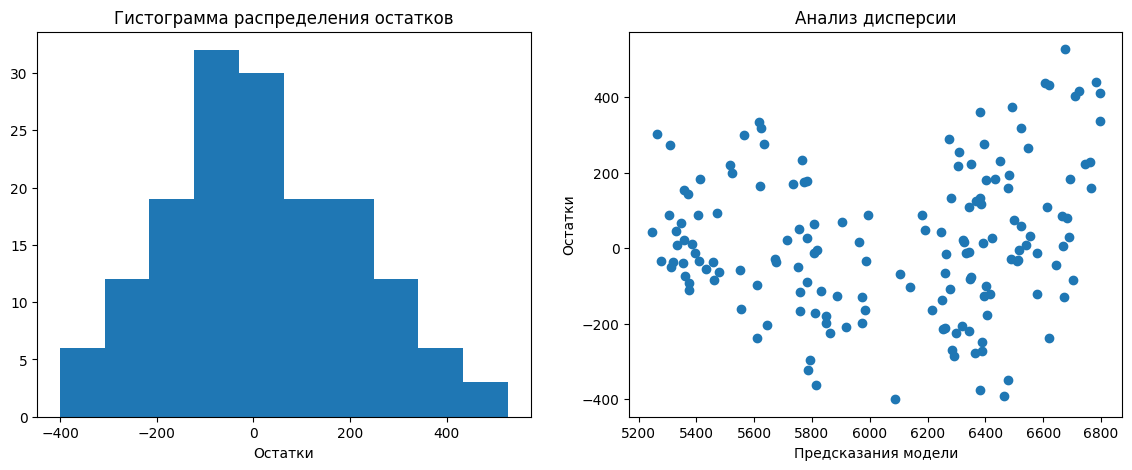

In [78]:
# остатки
residuals = y_test-predictions

# построение гистограммы частотности и диаграмму рассеяния остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма остатков выглядит немного смещенной влево относительно нуля, и снова правая граница почти 600 кг, левая -400 кг.

Диаграмма рассеяния снова выдает маленький разброс остатков для предсказанных значений в районе 5400 кг и большой разброс в районе 660 кг.

5.4  Оценим качество моделей по метрикам MSE, MAE, RMSE.

In [79]:
print('1 ая модель  mse =',round(mse), ' mae = ',round(mae), ' rmse = ',round(rmse))
print('2 ая модель  mse =',round(mse_2), ' mae = ',round(mae_2), ' rmse = ',round(rmse_2))
print('3 ая модель  mse =',round(mse_3), ' mae = ',round(mae_3), ' rmse = ',round(rmse_3))

1 ая модель  mse = 49471  mae =  181  rmse =  222
2 ая модель  mse = 42730  mae =  164  rmse =  207
3 ая модель  mse = 37644  mae =  154  rmse =  194


Итого, третья модель показала наилучшие результаты: самые маленькие метрики MSE, MAE, RMSE.

Поэтому ее можно признать лучшей моделью.

5.5 Доверительный интервал прогноза лучшей модели.

Ошибка третьей модели на тренировочных данных:

In [80]:
best_predict=model_lr_3.predict(X_train) -y_train

Описательные статистики ошибки модели:

In [81]:
best_predict.describe()

,yield
count,4.710000e+02
mean,5.850889e-13
std,1.839216e+02
min,-5.255954e+02
25%,-1.096045e+02
50%,-3.479484e+00
75%,1.321910e+02
max,6.675577e+02


Среднее ошибки практически 0, стандартное отклонение 190 кг, поэтому (если принять, что ошибка имеет нормальное распределение) можно записать, что

Удой = Прогноз +- 190 кг с вероятностью 68%

Удой = Прогноз +- 380 кг с вероятностью 96%

Удой = Прогноз +- 570 кг с вероятностью 99%

Для построения доверительного интервала переменной predictions = model_lr_3.predict(X_test) , который будет покрывать 95% случаев, воспользуемся функцией st.norm.interval для построения доверительного интервала нормального распределения, где первый аргумент -уровень значимости, второй и третий - выборочное среднее  и выборочное стандартное отклонение совокупности predictions.

In [82]:
print('95% доверительный интервал =', st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions)))

95% доверительный интервал = (np.float64(5997.417933697306), np.float64(6141.421983361367))


Доверительный интервал получился (5997, 6141).

5.6 С помощью третьей модели спрогнозируем удой коров, которые планирует купить фермер.

Добавим в датафрейм data_cow столбцы с ЭКЕ, СПО, protein_raw, которые получены из средних значений каждого из этих признаков в датафрейме data_ferma, увеличенные на 5%.

In [83]:
display(data_cow.head())

,breed,pasture_type,dad_breed,dad_name,fat_currrent,protein_current,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [84]:
s=['energy_feed_unit','sugar_protein','protein_raw']

In [85]:
#добавляем в датафрейм data_cow столбцы 'energy_feed_unit','sugar_protein'
for i in s:
    data_cow[i]=data_ferma[i].mean()*1.05

Чтобы получить прогноз удоя, нужно с датафреймом проделать те же действия, что и с тренировочной выборкой в 3 модели, а именно преобразовать СПО в категориальный бинарный признак, ЭКЕ возвести в квадрат, удалить все столбцы, которые не являются входными, закодировать категориальные признаки и отмасштабировать количественные.

Для контрольного примера выведем первые строки тренировочной выборки 3 модели, чтобы понимать, на что нам ориентироваться.

In [86]:
display(X_train.head())

,age_менее_2_лет,breed_РефлешнСоверинг,pasture_type_холмистое,sugar_protein_bin_True,dad_name_Буйный,dad_name_Геркулес,dad_name_Соловчик,energy_feed_unit_squared,protein_raw
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.027210,0.248479
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.053583,-1.392310
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-0.027210,1.124306
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.172927,0.858232
4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.549923,-0.671693


In [87]:
# преобразовываем sugar_protein в бинарный признак
data_cow['sugar_protein_bin']=data_cow['sugar_protein']>0.9

In [88]:
#возводим столбец energy_feed_unit в квадрат
data_cow['energy_feed_unit_squared']=data_cow['energy_feed_unit']*data_cow['energy_feed_unit']

Оказалось, что в data_ferma и data_cow в столбце pasture_type одни названия начинаются с заглавной буквы, в другой со строчной, поэтому в X_1 - копии X_train, приведем  все значения к нижнему регистру, и заново закодируем категориальные переменные в X_1, затем в data_cow.

In [89]:
X_1['pasture_type']=X_1['pasture_type'].str.lower()#приводим все значения к нижнему регистру как в data_cow['pasture_type']

In [90]:
#список признаков, которые не являются входными
s=['dad_breed','protein_current','energy_feed_unit','sugar_protein','fat_currrent']

#удаляем ненужные столбцы и переименуем датафрейм в Х
X = data_cow.drop(s, axis=1)
X= X.iloc[:, [4,0,1,3,5,6,2]]#меняем столбцы для единообразия с X_1

In [91]:
# список категориальных переменных
cat_col_names = ['age','breed','pasture_type','sugar_protein_bin','dad_name']

encoder = OneHotEncoder(drop='first', sparse_output=False)

encoder.fit(X_1[cat_col_names])# обучение кодирования на тренировочных данных
X_ohe=encoder.transform(X[cat_col_names])# кодирование категориальных переменных

encoder_col_names = encoder.get_feature_names_out()#названия новых столбцов
X_new_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)#датафрейм из закодированных данных

display(X_new_ohe.head())

,age_менее_2_лет,breed_РефлешнСоверинг,pasture_type_холмистое,sugar_protein_bin_True,dad_name_Буйный,dad_name_Геркулес,dad_name_Соловчик
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [92]:
#масштабируем количественные переменные
num_col_names = ['energy_feed_unit_squared','protein_raw']

scaler.fit(X_1[num_col_names])# настройка масштабирования на тренировочной выборке
X_scaled = scaler.transform(X[num_col_names]) #масштабирование количественных признаков

# создание датафрейма из масштабированных данных
X_new_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

display(X_new_scaled.head())

,energy_feed_unit_squared,protein_raw
0,0.525538,0.539677
1,0.525538,0.539677
2,0.525538,0.539677
3,0.525538,0.539677
4,0.525538,0.539677


In [93]:
# объединяем все преобразованные данные
# сбрасываем индексы в датафрейме с числовыми индексами

X_new = pd.concat([X_new_ohe, X_new_scaled], axis=1)
display(X_new.head())

,age_менее_2_лет,breed_РефлешнСоверинг,pasture_type_холмистое,sugar_protein_bin_True,dad_name_Буйный,dad_name_Геркулес,dad_name_Соловчик,energy_feed_unit_squared,protein_raw
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.525538,0.539677
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.525538,0.539677
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.525538,0.539677
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.525538,0.539677
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.525538,0.539677


Еще раз проверяем соответствие X_train и X_new - трансформированную data_cow для получения прогноза.


In [94]:
display(X_train.head())

,age_менее_2_лет,breed_РефлешнСоверинг,pasture_type_холмистое,sugar_protein_bin_True,dad_name_Буйный,dad_name_Геркулес,dad_name_Соловчик,energy_feed_unit_squared,protein_raw
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.027210,0.248479
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.053583,-1.392310
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-0.027210,1.124306
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.172927,0.858232
4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.549923,-0.671693


Теперь наши датафреймы имеют одинаковый вид, и можно применить модель регрессии к данным по коровам, которых собирается купить фермер.

In [95]:
#получение прогноза удоя коров
predictions = model_lr_3.predict(X_new)

#записываем прогноз в столбец yield
X_new['yield']=predictions

Получили прогноз удоя коров, который запишем в отдельный столбец yield.

In [96]:
display(X_new.head())

,age_менее_2_лет,breed_РефлешнСоверинг,pasture_type_холмистое,sugar_protein_bin_True,dad_name_Буйный,dad_name_Геркулес,dad_name_Соловчик,energy_feed_unit_squared,protein_raw,yield
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.525538,0.539677,6548.832545
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.525538,0.539677,6291.629172
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.525538,0.539677,6287.676207
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.525538,0.539677,6593.328537
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.525538,0.539677,6542.826625


Посчитаем, сколько коров имеет прогноз по удою больше 6000 кг.

In [97]:
#новый бинарный столбец-индикатор того, что прогноз удоя больше 6000 кг
X_new['ok']=X_new['yield']>6000

In [98]:
#сумма коров с прогнозом удоя больше 6000 кг
print(X_new['ok'].sum())

16


Итого, из 16 отобранных коров все будут иметь удой больше 6000 кг.

<a id='section6'></a>
## Обучение модели логистической регрессии

6.1 В [п. 4.2.5 ](#section8)  мы находили коэффициенты корреляции Фи для всех параметров датафрейма data_ferma.

Для переменной "вкус молока" корреляция оказалась самая большая с СПО (0.57) и с ЭКЕ (0.27). Примерно одинаково слабой корреляция окказалась с типом пастбища (0.22), жирностью (0.2), удоем, сырым протеином, возрастом (по 0.17) и белком (0.14).

Нулевой оказалась корреляция с породой и породой папы.

В качестве целевого признака  будем использовать вкус молока.

В качестве входных признаков будем использовать количественные: ЭКЕ, СПО, сырой протеин, жирность, белок,

и категориальные переменные: порода, тип пастбища, порода папы, возраст.


С целью избежания путаницы вкус молока закодируем бинарными значениями: 1, если вкусное, и 0, если не вкусное.

In [99]:
#меняем столбец taste на 1 и 0
data_ferma['taste']=(data_ferma['taste']=='вкусно')

In [100]:
display(data_ferma.head())

,id,yield,energy_feed_unit,protein_raw,sugar_protein,breed,pasture_type,dad_breed,fat,protein,taste,age,sugar_protein_bin,energy_feed_unit_squared,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,True,более_2_лет,False,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,True,менее_2_лет,False,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,False,более_2_лет,False,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,False,более_2_лет,False,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,True,менее_2_лет,False,163.84,Барин


In [101]:
# разбиваем признаки на входные и целевой
X = data_ferma.drop(columns=['id','yield','taste','sugar_protein_bin','energy_feed_unit_squared','dad_name'])
y = data_ferma['taste']
display(X.head())

,energy_feed_unit,protein_raw,sugar_protein,breed,pasture_type,dad_breed,fat,protein,age
0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,более_2_лет
1,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,менее_2_лет
2,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,более_2_лет
3,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,более_2_лет
4,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,менее_2_лет


Разбиваем данные на тренировочную и тестовую выборки.

In [102]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42

# разбиваем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

X_train['pasture_type']=X_train['pasture_type'].str.lower()
X_test['pasture_type']=X_test['pasture_type'].str.lower()

X_1=X_train.copy()
#display(y_test)

Кодируем категориальные признаки.

In [103]:
# список категориальных переменных
cat_col_names = ['age','pasture_type','breed','dad_breed']

# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse_output=False)

# обучение и кодирование тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# кодирование тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names])

# список новых столбцов
encoder_col_names = encoder.get_feature_names_out()

# создание датафрейма из закодированных данных
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)

# создание тренировочного и тестового датафрейма из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

Масштабируем количественные признаки.

In [104]:
#список количественных признаков
num_col_names = ['energy_feed_unit','sugar_protein','protein_raw','protein','fat']

# выбор метода масштабирования
scaler = StandardScaler()

# настройка и масштабирование тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# масштабирование тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# создание тренировочного и тестового датафрейма из масштабированных данных
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)



In [105]:
display(X_train.head())

,age_менее_2_лет,pasture_type_холмистое,breed_РефлешнСоверинг,dad_breed_Соверин,energy_feed_unit,sugar_protein,protein_raw,protein,fat
0,0.0,0.0,0.0,0.0,0.016344,0.814135,0.248479,1.666305,0.199205
1,0.0,0.0,0.0,0.0,0.095707,-1.072496,-1.392310,1.283462,-2.618012
2,0.0,1.0,0.0,0.0,0.016344,0.499697,1.124306,0.517774,0.076717
3,0.0,0.0,0.0,0.0,-1.174092,-0.758057,0.858232,0.134930,0.199205
4,0.0,1.0,1.0,0.0,0.571881,0.499697,-0.671693,-2.162133,0.566668


Обучим модель логистической регрессии на подготовленных данных.

In [106]:
# создаём объект для работы с моделью
clf = LogisticRegression()

# обучаем модель на данных
clf = clf.fit(X_train, y_train)

# получаем прогнозные метки классов
y_pred = clf.predict(X_test)

#display(y_pred)

Выведем коэффициенты обученной модели.

In [107]:
for feature_number, feature_name in enumerate(X_train.columns):
    weight = clf.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.6f}")

age_менее_2_лет     : +0.011157
pasture_type_холмистое: +0.576522
breed_РефлешнСоверинг: -0.086503
dad_breed_Соверин   : +0.346327
energy_feed_unit    : +0.279824
sugar_protein       : +0.244156
protein_raw         : +0.156762
protein             : +0.148698
fat                 : -0.161891


Самый большой вес имеет признак "вид пастбища" (0.58), порода папы имеет вес 0.34, ЭКЕ 0.28, СПО 0.24, все остальные признаки имеют вес от 0.13 до 0.16.

Оценим качество модели на тестовой выборке.

Рассчитаем accuracy.

In [108]:
acc = accuracy_score(y_test, y_pred)
print(acc)

0.6392405063291139


Наша модель с точностью 63,9% делает верный прогноз.

Построим матрицу ошибок модели.

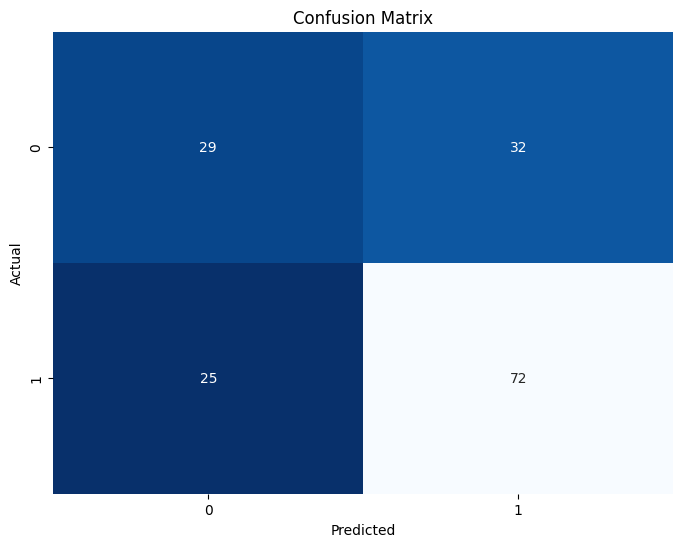

In [109]:
# матрица ошибок
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r',cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Согласно этой таблице, имеем предсказаний:

72  True Positive,

25  False Negative,
  
32  False Positive,
  
29  True Negative.

Рассчитаем метрики recall и precision.

In [110]:
recall = recall_score(y_test,y_pred)
precision =precision_score(y_test,y_pred)

print('precision: ',round(precision,3))
print('recall: ',round(recall ,3))

precision:  0.692
recall:  0.742


Итого, точность модели оказалась 66.5%,

метрика precision 0.69,

метрика recall  0.74.

6.2 Анализ модели

Ошибки классификации включают в себя оценки двух видов: False Positive и False Negative. В статистике их называют ошибками первого рода и второго  рода.

False Positive: модель неправильно классифицировала Negative как  Positive, то есть невкусное молоко приняла за вкусное.

False Negative: модель неправильно классифицировала Positive  как Negative  , то есть вкусное молоко приняла за невкусное.

С точки зрения потребителя, для которого вкус молока - главный фактор при покупке, принять вкусное молоко за невкусное гораздо хуже, чем наоборот: признать вкусное молоко невкусным.

Поэтому ошибка 1 рода в данной задаче имеет большее значение, ее минимизировать главнее. Следовательно, для нашего анализа более важна метрика precision=TP/(TP+FP).  

Попробуем разные пороги принадлежности к классам.

In [111]:
#Задаем список порогов
thresholds = [0.5,0.6,0.7,0.8,0.85]

# создаём переменную, которая будет хранить список новых колонок
columns = []

# создаем списки для хранения подсчитанных метрик recall и precision для всех порогов
recall=[]
precision=[]

# столбец вероятности того, рассчитанные моделью значения на тестовой выборке принадлежат классу 1
y_proba = clf.predict_proba(X_test)[:,1]

#создаем датафрейм с тестовыми значениями y_test и вероятностями, рассчичатнными по тестовой выборке X_test
data = pd.DataFrame(zip(y_test, y_proba),columns = ['y_valid', 'y_proba'])

#создаем расчётные столбцы с отметками класса для каждого порога
#считаем метрики recall и precision для всех порогов
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda y_proba: 1 if y_proba>= i else 0)
    recall.append(recall_score(y_test,data['y_pred_'+str(i)],zero_division=0))
    precision.append(precision_score(y_test,data['y_pred_'+str(i)],zero_division=0))

#print(data.head())

j=0 #выводим на экран метрики recall и precision для всех порогов
for i in thresholds:
    print("Threshhold=",i,'Recall=',round(recall[j], 2),'Precision=',round(precision[j], 2))
    j=j+1

Threshhold= 0.5 Recall= 0.74 Precision= 0.69
Threshhold= 0.6 Recall= 0.49 Precision= 0.75
Threshhold= 0.7 Recall= 0.27 Precision= 0.81
Threshhold= 0.8 Recall= 0.04 Precision= 0.8
Threshhold= 0.85 Recall= 0.0 Precision= 0.0


Переберем пороги от 0.5 до 0.99 с шагом 0.001 и посмотрим, как будет меняться Precision.

In [112]:
#Задаем список порогов
th=0.5
thresholds = []

while th<0.99:
    thresholds.append(th)
    th+=0.001

 # создаём переменную, которая будет хранить список новых колонок
columns = []

# создаем списки для хранения подсчитанных метрик recall и precision для всех порогов
precision=[]

# столбец вероятности того, рассчитанные моделью значения на тестовой выборке принадлежат классу 1
y_proba = clf.predict_proba(X_test)[:,1]

#создаем датафрейм с тестовыми значениями y_test и вероятностями, рассчичатнными по тестовой выборке X_test
data = pd.DataFrame(zip(y_test, y_proba),columns = ['y_valid', 'y_proba'])

#создаем расчётные столбцы с отметками класса для каждого порога
#считаем метрики  precision для всех порогов
for i in thresholds:
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda y_proba: 1 if y_proba>= i else 0)
    precision.append(precision_score(y_test,data['y_pred_'+str(i)],zero_division=0))
   #pd.concat(precision, precision_score(y_test,data['y_pred_'+str(i)],zero_division=0),axis=0)

precision_formatted = [ '%.2f' % elem for elem in precision ]
print(precision_formatted)
print('Максимальный precision ',max(precision_formatted))

max_value = max(precision_formatted)
max_index = precision_formatted.index(max_value)
print('Порог для максимального precision ',0.5+max_index*0.001)

['0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.68', '0.69', '0.69', '0.69', '0.69', '0.68', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.69', '0.68', '0.68', '0.68', '0.70', '0.70', '0.70', '0.70', '0.69', '0.70', '0.71', '0.71', '0.71', '0.71', '0.71', '0.71', '0.71', '0.71', '0.71', '0.71', '0.72', '0.72', '0.72', '0.72', '0.72', '0.72', '0.72', '0.72', '0.71', '0.71', '0.72', '0.72', '0.72', '0.72', '0.72', '0.72', '0.72', '0.71', '0.71', '0.72', '0.72', '0.72', '0.72', '0.72', '0.72', '0.73', '0.73', '0.72', '0.72', '0.73', '0.73', '0.73', '0.73', '0.72', '0.74', '0.74', '0.74', '0.74', '0.74', '0.73', '0.73', '0.73', '0.73', '0.74', '0.74', '0.74', '0.74', '0.74', '0.75', '0.75', '0.75', '0.75', '0.75', '0.75', '0.75', '0.75', '0.75', '0.75', '0.75', '0.75', '0.75', '0.74', '0.74', '0.74', '0.74', '0.74', '0.74', '0.74', '0.74', '0.74', '0.74', '0.75', '0.75', '0.76', '0.76',

Максимальное достигнутое значение precision 0.88 достигается при пороге 0.786.

Точность модели так же оказалась невысока. Поэтому использовать модель можно , но эффективность ее вызывает сомнения.

Можно было бы преобразовать исходные данные, как в задаче с линейной регрессией, хотя и там в результате преобразований R^2 модели увеличилось с 0.81 до 0.86.

Можно было бы обратиться в "Экоферму" за разъяснениями по исходным данным: жирность молока и СПО, возможно более точные исходные данные могли бы улучшить качество модели.

Раз вкус молока зависит от типа пастбища, наверняка он зависит от места выпаса, можно было бы запросить эту информацию.

6.3 С помощью обученной модели спрогнозируем вкус молока коров, которые фермер планирует купить. Для этого с датасетом data_cow нужно проделать преобразования, чтобы он имел такой же вид, как и X_train.

In [113]:
display(X_train.head())

,age_менее_2_лет,pasture_type_холмистое,breed_РефлешнСоверинг,dad_breed_Соверин,energy_feed_unit,sugar_protein,protein_raw,protein,fat
0,0.0,0.0,0.0,0.0,0.016344,0.814135,0.248479,1.666305,0.199205
1,0.0,0.0,0.0,0.0,0.095707,-1.072496,-1.392310,1.283462,-2.618012
2,0.0,1.0,0.0,0.0,0.016344,0.499697,1.124306,0.517774,0.076717
3,0.0,0.0,0.0,0.0,-1.174092,-0.758057,0.858232,0.134930,0.199205
4,0.0,1.0,1.0,0.0,0.571881,0.499697,-0.671693,-2.162133,0.566668


In [114]:
#добавляем в датафрейм data_cow столбцы 'energy_feed_unit','sugar_protein','protein_raw'
s=['energy_feed_unit','sugar_protein','protein_raw']
for i in s:
    data_cow[i]=data_ferma[i].mean()*1.05

In [115]:
s=['dad_name']#удаляем ненужные признаки
X = data_cow.drop(s, axis=1)

#переименовываем столбцы protein_current и fat_currrent для единообразия с X_1 - тренировочной выборкой
X=X.rename(columns={'protein_current': 'protein', 'fat_currrent': 'fat'})

In [116]:
X_1['pasture_type']=X_1['pasture_type'].str.lower()#приводим все значения к нижнему регистру как в data_cow['pasture_type']

In [117]:
# кодирование категориальных переменных
cat_col_names =['age','pasture_type','breed','dad_breed']

encoder = OneHotEncoder(drop='first', sparse_output=False)

encoder.fit(X_1[cat_col_names])# обучение кодирования на тренировочных данных

X_ohe = encoder.transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
X_new_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

display(X_new_ohe.head())

,age_менее_2_лет,pasture_type_холмистое,breed_РефлешнСоверинг,dad_breed_Соверин
0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0
3,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [118]:
#масштабирование количественных признаков
num_col_names = ['energy_feed_unit','sugar_protein','protein_raw','protein','fat']

scaler.fit(X_1[num_col_names])# настройка масштабирования на тренировочной выборке
X_scaled = scaler.transform(X[num_col_names]) #масштабирование количественных признаков

# создание датафрейма из масштабированных данных
X_new_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

display(X_new_scaled.head())

,energy_feed_unit,sugar_protein,protein_raw,protein,fat
0,0.548924,1.404395,0.539677,0.134930,-0.168258
1,0.548924,1.404395,0.539677,2.049149,-0.413233
2,0.548924,1.404395,0.539677,-0.630758,-0.107014
3,0.548924,1.404395,0.539677,-5.607727,-1.270647
4,0.548924,1.404395,0.539677,-0.630758,0.199205


In [119]:
# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами

X_new_1= pd.concat([X_new_ohe, X_new_scaled], axis=1)
display(X_new_1.head())
display(X_train.head())

,age_менее_2_лет,pasture_type_холмистое,breed_РефлешнСоверинг,dad_breed_Соверин,energy_feed_unit,sugar_protein,protein_raw,protein,fat
0,0.0,1.0,0.0,0.0,0.548924,1.404395,0.539677,0.134930,-0.168258
1,1.0,0.0,0.0,1.0,0.548924,1.404395,0.539677,2.049149,-0.413233
2,0.0,0.0,1.0,1.0,0.548924,1.404395,0.539677,-0.630758,-0.107014
3,0.0,1.0,1.0,0.0,0.548924,1.404395,0.539677,-5.607727,-1.270647
4,0.0,0.0,1.0,0.0,0.548924,1.404395,0.539677,-0.630758,0.199205


,age_менее_2_лет,pasture_type_холмистое,breed_РефлешнСоверинг,dad_breed_Соверин,energy_feed_unit,sugar_protein,protein_raw,protein,fat
0,0.0,0.0,0.0,0.0,0.016344,0.814135,0.248479,1.666305,0.199205
1,0.0,0.0,0.0,0.0,0.095707,-1.072496,-1.392310,1.283462,-2.618012
2,0.0,1.0,0.0,0.0,0.016344,0.499697,1.124306,0.517774,0.076717
3,0.0,0.0,0.0,0.0,-1.174092,-0.758057,0.858232,0.134930,0.199205
4,0.0,1.0,1.0,0.0,0.571881,0.499697,-0.671693,-2.162133,0.566668


In [120]:
# столбец вероятности того, рассчитанные моделью значения на тестовой выборке принадлежат классу 1
y_proba = clf.predict_proba(X_new_1)[:,1]

predictions= y_proba >=0.5+max_index*0.001

data_cow['taste']=predictions #записываем прогноз в столбец taste
display(data_cow.head())


,breed,pasture_type,dad_breed,dad_name,fat_currrent,protein_current,age,energy_feed_unit,sugar_protein,protein_raw,sugar_protein_bin,energy_feed_unit_squared,taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271073,0.958772,2019.532273,True,233.205675,False
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271073,0.958772,2019.532273,True,233.205675,False
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271073,0.958772,2019.532273,True,233.205675,False
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.271073,0.958772,2019.532273,True,233.205675,False
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271073,0.958772,2019.532273,True,233.205675,False


Итого, в столбце taste мы получили прогноз по вкусу молока: 1, если вкусное, 0, если невкусное.

Выведем число коров с вкусным молоком при разных порогах вероятности.

In [121]:
s=[0.5+max_index*0.001,0.7,0.6,0.5]
for i in s:
  predictions= y_proba >i
  data_cow['taste']=predictions
  print("Порог ", i, "число коров с вкусным молоком ",data_cow['taste'].sum())

Порог  0.786 число коров с вкусным молоком  3
Порог  0.7 число коров с вкусным молоком  6
Порог  0.6 число коров с вкусным молоком  10
Порог  0.5 число коров с вкусным молоком  13


При пороге 0.786 модель предсказывает только 3 коровы с вкусным молоком из 16.
       
При пороге 0.7 - 6 коров предсказаны со вкусным молоком,
    
При пороге 0.6 - 10 коров предсказаны со вкусным молоком,
      
При пороге 0.5 уже 13 коров предсказаны со вкусным молоком.
    
Вывод: увеличивая метрику precision, мы добьемся точности прогноза вкусного молока, но покупать будет некого.

<a id='section7'></a>
## Итоговые выводы

Добавим в датафрейм с коровами, которых собирается купить фермер, найденные прогнозные значения.

In [122]:
data_cow['yield']=X_new['yield']
display(data_cow.head())

,breed,pasture_type,dad_breed,dad_name,fat_currrent,protein_current,age,energy_feed_unit,sugar_protein,protein_raw,sugar_protein_bin,energy_feed_unit_squared,taste,yield
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271073,0.958772,2019.532273,True,233.205675,True,6548.832545
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271073,0.958772,2019.532273,True,233.205675,True,6291.629172
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271073,0.958772,2019.532273,True,233.205675,True,6287.676207
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.271073,0.958772,2019.532273,True,233.205675,True,6593.328537
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271073,0.958772,2019.532273,True,233.205675,True,6542.826625


Отберем из датафрейма те строки, где удой больше 6000 кг и молоко вкусное.

In [123]:
data_cow_best=data_cow[(data_cow['yield']>6000) & (data_cow['taste']==1)]

Оценим, сколько строк в новом датафрейме.

In [124]:
display(data_cow_best.shape[0])

11

Итого, 11 коров из отобранных 16 будут иметь нужный удой и вкусное молоко, их и рекомендуется купить фермеру.

В целом, при выборе коров фермеру следует выбирать взрослых коров (старше 2 лет), которые пасутся на холмистых пастбищах, порода папы Айдиал, которые питаются кормом с более высоким СПО и ЭКЕ: такие коровы дают больший удой.

Линейная и логистическая регрессии показали не самый лучший результат, возможно из-за качества входных данных или неучтенных факторов, или нелинейной зависимости между признаками.

С помощью преобразований переменных из количественных в категориальные, а также численных преобразований над количественными признаками удалось увеличить коэффициент детерминации линейной регрессии на 0.03.

Добавив новый признак в датафрейм, удалось увеличить коэффициент детерминации еще на 0.02, при этом метрики mae и rmse уменьшились на 27 кг по сравнению с первой моделью.

Для улучшения модели линейной регресии можно было бы еще раз запросить данные по жирности и СПО, возможно улучшение их качества могло бы увеличить точность модели. Кроме того, можно добавить новые признаки, например место выпаса, которые наверняка влияют на удой и вкус молока.

При анализе рисков или экономических расчетов необходимо также принимать во внимание ошибки 1 и 2 рода: сколько раз модель ошибочно принимала класс 0 за класс 1 и наоборот: сколько раз она принимала класс 1 за класс 0. Эти ошибки имеют разный вес для каждой конкретной задачи, и соответственно разную экономическую стоимость, поэтому им необходимо уделять пристальное внимание.

Ошибка 1 рода характеризуется метрикой precision, ошибка 2 рода - метрикой recall.

В нашей задаче нужно было уменьшить ошибку 1 рода, удалось добиться, чтобы метрика precision равнялась 0.88, при значении порога 0.786.

Таким образом, рассмотренные модели можно попытаться улучшить путем введения новых признаков или преобразованием имеющихся.
